# This Notebook

In this notebook, we'll be working on a data hackathon hosted by Analytics Vidhya. FinMan is a Financial Distribution company. Over the last 10 years, they have created an offline distribution channel across India. They sell financial products to consumers by hiring agents into their network. The agents are freelancers and get commission when they make a product sale. Managers at FinMan are primarily responsible for recruiting agents. Once a manager has identified a potential applicant, they explain the business opportunity to the agent. Once the applicant consents to the contract, an petition is made to FinMan for the applicant to become an agent. The date on which this application is submitted is known as application_receipt_date. Over the next 3 months, the potential agent has to undergo a 7 day training at the FinMan branch (to learn about Sales processes and various products) and clear a subsequent examination in order to become a FinMan agent.

As is obvious in the above process, there is a significant investment which FinMan makes in identifying, training and recruiting these agents. However, there are a set of agents who do not bring in the expected resultant business. The purpose is thus to develop a classifier to identify from the pool of applicants those who will meet business expectations once hired. In the training data, there is a boolean column with zeroes and ones presenting whether a previously hired agent met the business source expectation called `Business_Sourced(Target)` that will serve as our variable to be predicted. From the problem statement, we have a description of all the columns in both train and test sets:

```
Variable 	                    Definition
ID 	                            Unique Application ID
Office_PIN 	                    PINCODE of Fintro's Offices
Application_Receipt_Date 	    Date of Application
Applicant_City_PIN 	            PINCODE of Applicant Address
Applicant_Gender 	            Applicant's Gender
Applicant_BirthDate 	        Applicant's Birthdate
Applicant_Marital_Status 	    Applicant's Marital Status
Applicant_Occupation 	        Applicant's Occupation
Applicant_Qualification 	    Applicant's Educational Qualification
Manager_DOJ 	                Manager's Date of Joining
Manager_Joining_Designation 	Manager's Joining Designation in Fintro
Manager_Current_Designation 	Manager's Designation at the time of application sourcing
Manager_Grade 	                Manager's Grade in Fintro
Manager_Status 	                Current Employment Status (Probation / Confirmation)
Manager_Gender 	                Manager's Gender
Manager_DoB 	                Manager's Birthdate
Manager_Num_Application 	    No. of Applications sourced in last 3 months by the Manager
Manager_Num_Coded 	            No. of agents recruited by the manager in last 3 months
Manager_Business 	            Amount of business sourced by the manager in last 3 months
Manager_Num_Products 	        Number of products sold by the manager in last 3 months
Manager_Business2 	            Amount of business sourced by the manager in last 3 months excluding business from their Category A advisor
Manager_Num_Products2 	        Number of products sold by the manager in last 3 months excluding business from their Category A advisor
```

Looking at this list, there are some columns that, even if they did coincidentally increase the performance of the identifier, I believe we will want to exclude. Some, we may generate a feature from, before removal, such as seeing if the applicant gender and manager gender are the same, but in isolation it wouldn't make sense to include the following as predictors in an ethical classifier: Applicant_City_PIN, Applicant_Gender, Applicant_BirthDate, Applicant_Marital_Status, Manager_Gender, Manager_DoB.

# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from os import path

In [2]:
train_set = pd.read_csv('./data/train_data.csv')
test_set = pd.read_csv('./data/test_data.csv')

In [3]:
train_set.head()

ID  Office_PIN Application_Receipt_Date  Applicant_City_PIN  \
0  FIN1000001      842001                4/16/2007            844120.0   
1  FIN1000002      842001                4/16/2007            844111.0   
2  FIN1000003      800001                4/16/2007            844101.0   
3  FIN1000004      814112                4/16/2007            814112.0   
4  FIN1000005      814112                4/16/2007            815351.0   

  Applicant_Gender Applicant_BirthDate Applicant_Marital_Status  \
0                M          12/19/1971                        M   
1                M           2/17/1983                        S   
2                M           1/16/1966                        M   
3                M            2/3/1988                        S   
4                M            7/4/1985                        M   

  Applicant_Occupation Applicant_Qualification Manager_DOJ  ...  \
0               Others                Graduate  11/10/2005  ...   
1               Others               Class XII  11/10/2005  ...   
2             Business               Class XII   5/27/2006  ...   
3             Salaried               Class XII   8/21/2003  ...   
4               Others               Class XII    5/8/2006  ...   

  Manager_Status Manager_Gender  Manager_DoB Manager_Num_Application  \
0   Confirmation              M    2/17/1978                     2.0   
1   Confirmation              M    2/17/1978                     2.0   
2   Confirmation              M     3/3/1969                     0.0   
3   Confirmation              F    8/14/1978                     0.0   
4   Confirmation              M     2/7/1971                     2.0   

  Manager_Num_Coded Manager_Business  Manager_Num_Products  Manager_Business2  \
0               1.0         335249.0                  28.0           335249.0   
1               1.0         335249.0                  28.0           335249.0   
2               0.0         357184.0                  24.0           357184.0   
3               0.0         318356.0                  22.0           318356.0   
4               1.0         230402.0                  17.0           230402.0   

   Manager_Num_Products2  Business_Sourced  
0                   28.0                 0  
1                   28.0                 1  
2                   24.0                 0  
3                   22.0                 0  
4                   17.0                 0  

[5 rows x 23 columns]

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           9527 non-null   object 
 1   Office_PIN                   9527 non-null   int64  
 2   Application_Receipt_Date     9527 non-null   object 
 3   Applicant_City_PIN           9430 non-null   float64
 4   Applicant_Gender             9460 non-null   object 
 5   Applicant_BirthDate          9454 non-null   object 
 6   Applicant_Marital_Status     9454 non-null   object 
 7   Applicant_Occupation         8306 non-null   object 
 8   Applicant_Qualification      9441 non-null   object 
 9   Manager_DOJ                  8844 non-null   object 
 10  Manager_Joining_Designation  8844 non-null   object 
 11  Manager_Current_Designation  8844 non-null   object 
 12  Manager_Grade                8844 non-null   float64
 13  Manager_Status    

In [5]:
train_set.dropna().shape

(7730, 23)

In [6]:
train_set.dropna(thresh = 2).shape

(9527, 23)

So, while almost 2000 rows have information missing, no individual rows have two or more missing values; it is only ever one.

In [7]:
train_set.describe(include = ['int64','float64'])

Office_PIN  Applicant_City_PIN  Manager_Grade  \
count    9527.000000         9430.000000    8844.000000   
mean   452894.372205       456784.547296       3.264134   
std    235690.618252       239291.081207       1.137449   
min    110005.000000       110001.000000       1.000000   
25%    226001.000000       226020.000000       2.000000   
50%    416001.000000       422005.500000       3.000000   
75%    695014.000000       695017.000000       4.000000   
max    851101.000000       995657.000000      10.000000   

       Manager_Num_Application  Manager_Num_Coded  Manager_Business  \
count              8844.000000        8844.000000      8.844000e+03   
mean                  1.939733           0.758933      1.843710e+05   
std                   2.150529           1.188644      2.747163e+05   
min                   0.000000           0.000000     -2.652890e+05   
25%                   0.000000           0.000000      0.000000e+00   
50%                   1.000000           0.000000      1.021780e+05   
75%                   3.000000           1.000000      2.471165e+05   
max                  22.000000           9.000000      3.578265e+06   

       Manager_Num_Products  Manager_Business2  Manager_Num_Products2  \
count           8844.000000       8.844000e+03            8844.000000   
mean               7.152307       1.829263e+05               7.131275   
std                8.439351       2.718021e+05               8.423597   
min                0.000000      -2.652890e+05               0.000000   
25%                0.000000       0.000000e+00               0.000000   
50%                5.000000       1.017140e+05               5.000000   
75%               11.000000       2.464612e+05              11.000000   
max              101.000000       3.578265e+06             101.000000   

       Business_Sourced  
count        9527.00000  
mean            0.34292  
std             0.47471  
min             0.00000  
25%             0.00000  
50%             0.00000  
75%             1.00000  
max             1.00000

In [8]:
train_set.describe(include = ['object'])

ID Application_Receipt_Date Applicant_Gender  \
count         9527                     9527             9460   
unique        9527                      357                2   
top     FIN1000001                 5/9/2007                M   
freq             1                      165             7179   

       Applicant_BirthDate Applicant_Marital_Status Applicant_Occupation  \
count                 9454                     9454                 8306   
unique                5836                        4                    5   
top               1/3/1978                        M             Salaried   
freq                    24                     6177                 3787   

       Applicant_Qualification Manager_DOJ Manager_Joining_Designation  \
count                     9441        8844                        8844   
unique                      11         646                           8   
top                  Class XII    7/9/2007                     Level 1   
freq                      5806         106                        4632   

       Manager_Current_Designation Manager_Status Manager_Gender Manager_DoB  
count                         8844           8844           8844        8844  
unique                           5              2              2        1245  
top                        Level 2   Confirmation              M   2/11/1961  
freq                          3208           5277           7627          45

In [9]:
test_set.head()

ID  Office_PIN Application_Receipt_Date  Applicant_City_PIN  \
0  FIN1009528      284001                 7/2/2008            284001.0   
1  FIN1009529      800001                 7/2/2008            800026.0   
2  FIN1009530      800001                 7/2/2008                 NaN   
3  FIN1009531      800001                 7/2/2008            844112.0   
4  FIN1009532      533101                 7/2/2008            533102.0   

  Applicant_Gender Applicant_BirthDate Applicant_Marital_Status  \
0                M            8/5/1982                        S   
1                M           3/11/1968                        M   
2                M          12/16/1984                        S   
3                M            6/7/1971                        S   
4                M           7/22/1978                        S   

  Applicant_Occupation             Applicant_Qualification Manager_DOJ  ...  \
0             Salaried                            Graduate   5/26/2008  ...   
1             Salaried                            Graduate   6/24/2008  ...   
2                  NaN                            Graduate         NaN  ...   
3             Salaried                            Graduate         NaN  ...   
4                  NaN  Masters of Business Administration   12/4/2007  ...   

  Manager_Grade Manager_Status  Manager_Gender Manager_DoB  \
0           2.0      Probation               F  10/14/1978   
1           2.0      Probation               M    3/3/1971   
2           NaN            NaN             NaN         NaN   
3           NaN            NaN             NaN         NaN   
4           3.0   Confirmation               M   6/23/1977   

  Manager_Num_Application Manager_Num_Coded  Manager_Business  \
0                     1.0               0.0               0.0   
1                     2.0               0.0               0.0   
2                     NaN               NaN               NaN   
3                     NaN               NaN               NaN   
4                     4.0               1.0           97352.0   

   Manager_Num_Products  Manager_Business2  Manager_Num_Products2  
0                   0.0                0.0                    0.0  
1                   0.0                0.0                    0.0  
2                   NaN                NaN                    NaN  
3                   NaN                NaN                    NaN  
4                   3.0            97352.0                    3.0  

[5 rows x 22 columns]

In [10]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           5045 non-null   object 
 1   Office_PIN                   5045 non-null   int64  
 2   Application_Receipt_Date     5045 non-null   object 
 3   Applicant_City_PIN           5011 non-null   float64
 4   Applicant_Gender             5023 non-null   object 
 5   Applicant_BirthDate          5022 non-null   object 
 6   Applicant_Marital_Status     5015 non-null   object 
 7   Applicant_Occupation         4041 non-null   object 
 8   Applicant_Qualification      5001 non-null   object 
 9   Manager_DOJ                  4221 non-null   object 
 10  Manager_Joining_Designation  4221 non-null   object 
 11  Manager_Current_Designation  4221 non-null   object 
 12  Manager_Grade                4221 non-null   float64
 13  Manager_Status    

In [11]:
test_set.describe(include = ['int64','float64'])

Office_PIN  Applicant_City_PIN  Manager_Grade  \
count    5045.000000         5011.000000    4221.000000   
mean   431478.138751       433049.851527       3.352760   
std    230425.779147       231655.574011       0.994504   
min    110005.000000       110001.000000       2.000000   
25%    221010.000000       224141.000000       3.000000   
50%    400705.000000       411005.000000       3.000000   
75%    641018.000000       641002.000000       4.000000   
max    851101.000000       884112.000000       8.000000   

       Manager_Num_Application  Manager_Num_Coded  Manager_Business  \
count              4221.000000        4221.000000      4.221000e+03   
mean                  2.521204           1.104951      1.115425e+05   
std                   2.491566           1.473985      1.640698e+05   
min                   0.000000           0.000000     -3.196900e+04   
25%                   0.000000           0.000000      0.000000e+00   
50%                   2.000000           1.000000      5.002600e+04   
75%                   4.000000           2.000000      1.757620e+05   
max                  17.000000          10.000000      2.196480e+06   

       Manager_Num_Products  Manager_Business2  Manager_Num_Products2  
count           4221.000000       4.221000e+03            4221.000000  
mean               3.864250       9.895073e+04               3.495143  
std                4.688678       1.469193e+05               4.241165  
min                0.000000      -3.196900e+04               0.000000  
25%                0.000000       0.000000e+00               0.000000  
50%                2.000000       4.653700e+04               2.000000  
75%                7.000000       1.537820e+05               6.000000  
max               31.000000       2.196480e+06              30.000000

In [12]:
test_set.describe(include = ['object'])

ID Application_Receipt_Date Applicant_Gender  \
count         5045                     5045             5023   
unique        5045                      143                2   
top     FIN1009528                7/21/2008                M   
freq             1                      273             3900   

       Applicant_BirthDate Applicant_Marital_Status Applicant_Occupation  \
count                 5022                     5015                 4041   
unique                3792                        4                    5   
top               1/3/1979                        M             Salaried   
freq                    11                     4089                 2560   

       Applicant_Qualification Manager_DOJ Manager_Joining_Designation  \
count                     5001        4221                        4221   
unique                       8         465                           6   
top                   Graduate    8/4/2008                     Level 2   
freq                      3375         150                        1441   

       Manager_Current_Designation Manager_Status Manager_Gender Manager_DoB  
count                         4221           4221           4221        4221  
unique                           5              2              2         895  
top                        Level 3      Probation              M    5/6/1972  
freq                          1530           2292           3694          32

In [13]:
dates = ['Application_Receipt_Date','Applicant_BirthDate','Manager_DOJ','Manager_DoB']
for column in dates:
    train_set[column] = pd.to_datetime(train_set[column], infer_datetime_format = True)
    test_set[column] = pd.to_datetime(test_set[column], infer_datetime_format = True)

In [14]:
train_set.head()

ID  Office_PIN Application_Receipt_Date  Applicant_City_PIN  \
0  FIN1000001      842001               2007-04-16            844120.0   
1  FIN1000002      842001               2007-04-16            844111.0   
2  FIN1000003      800001               2007-04-16            844101.0   
3  FIN1000004      814112               2007-04-16            814112.0   
4  FIN1000005      814112               2007-04-16            815351.0   

  Applicant_Gender Applicant_BirthDate Applicant_Marital_Status  \
0                M          1971-12-19                        M   
1                M          1983-02-17                        S   
2                M          1966-01-16                        M   
3                M          1988-02-03                        S   
4                M          1985-07-04                        M   

  Applicant_Occupation Applicant_Qualification Manager_DOJ  ...  \
0               Others                Graduate  2005-11-10  ...   
1               Others               Class XII  2005-11-10  ...   
2             Business               Class XII  2006-05-27  ...   
3             Salaried               Class XII  2003-08-21  ...   
4               Others               Class XII  2006-05-08  ...   

  Manager_Status Manager_Gender  Manager_DoB Manager_Num_Application  \
0   Confirmation              M   1978-02-17                     2.0   
1   Confirmation              M   1978-02-17                     2.0   
2   Confirmation              M   1969-03-03                     0.0   
3   Confirmation              F   1978-08-14                     0.0   
4   Confirmation              M   1971-02-07                     2.0   

  Manager_Num_Coded Manager_Business  Manager_Num_Products  Manager_Business2  \
0               1.0         335249.0                  28.0           335249.0   
1               1.0         335249.0                  28.0           335249.0   
2               0.0         357184.0                  24.0           357184.0   
3               0.0         318356.0                  22.0           318356.0   
4               1.0         230402.0                  17.0           230402.0   

   Manager_Num_Products2  Business_Sourced  
0                   28.0                 0  
1                   28.0                 1  
2                   24.0                 0  
3                   22.0                 0  
4                   17.0                 0  

[5 rows x 23 columns]

In [15]:
test_set.head()

ID  Office_PIN Application_Receipt_Date  Applicant_City_PIN  \
0  FIN1009528      284001               2008-07-02            284001.0   
1  FIN1009529      800001               2008-07-02            800026.0   
2  FIN1009530      800001               2008-07-02                 NaN   
3  FIN1009531      800001               2008-07-02            844112.0   
4  FIN1009532      533101               2008-07-02            533102.0   

  Applicant_Gender Applicant_BirthDate Applicant_Marital_Status  \
0                M          1982-08-05                        S   
1                M          1968-03-11                        M   
2                M          1984-12-16                        S   
3                M          1971-06-07                        S   
4                M          1978-07-22                        S   

  Applicant_Occupation             Applicant_Qualification Manager_DOJ  ...  \
0             Salaried                            Graduate  2008-05-26  ...   
1             Salaried                            Graduate  2008-06-24  ...   
2                  NaN                            Graduate         NaT  ...   
3             Salaried                            Graduate         NaT  ...   
4                  NaN  Masters of Business Administration  2007-12-04  ...   

  Manager_Grade Manager_Status  Manager_Gender Manager_DoB  \
0           2.0      Probation               F  1978-10-14   
1           2.0      Probation               M  1971-03-03   
2           NaN            NaN             NaN         NaT   
3           NaN            NaN             NaN         NaT   
4           3.0   Confirmation               M  1977-06-23   

  Manager_Num_Application Manager_Num_Coded  Manager_Business  \
0                     1.0               0.0               0.0   
1                     2.0               0.0               0.0   
2                     NaN               NaN               NaN   
3                     NaN               NaN               NaN   
4                     4.0               1.0           97352.0   

   Manager_Num_Products  Manager_Business2  Manager_Num_Products2  
0                   0.0                0.0                    0.0  
1                   0.0                0.0                    0.0  
2                   NaN                NaN                    NaN  
3                   NaN                NaN                    NaN  
4                   3.0            97352.0                    3.0  

[5 rows x 22 columns]

In [16]:
for column in train_set.columns:
    if train_set[column].dtype == 'object' and column != 'ID':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Gender
M      7179
F      2281
NaN      67
Name: Applicant_Gender, dtype: int64
Column Name: Applicant_Marital_Status
M      6177
S      3267
NaN      73
W         6
D         4
Name: Applicant_Marital_Status, dtype: int64
Column Name: Applicant_Occupation
Salaried         3787
Business         2303
Others           1966
NaN              1221
Self Employed     149
Student           101
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Class XII                                                           5806
Graduate                                                            3196
Class X                                                              225
Others                                                               132
NaN                                                                   86
Masters of Business Administration                                    74
Associate / Fellow of Institute of Chartered Accountans of India       3

In [17]:
for column in test_set.columns:
    if test_set[column].dtype == 'object' and column != 'ID':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_set[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Gender
M      3900
F      1123
NaN      22
Name: Applicant_Gender, dtype: int64
Column Name: Applicant_Marital_Status
M      4089
S       907
NaN      30
W        12
D         7
Name: Applicant_Marital_Status, dtype: int64
Column Name: Applicant_Occupation
Salaried         2560
NaN              1004
Business          646
Others            506
Self Employed     310
Student            19
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Graduate                                                                              3375
Class XII                                                                             1357
Others                                                                                 171
Masters of Business Administration                                                      71
NaN                                                                                     44
Class X                                                

In columns `Applicant_Qualification` and `Manager_Joining_Designation` there are different unique identifiers. We will have to bin some of them to make the different indentifiers uniform for best performance. We're also seeing significant and annoying NaN counts in these columns, as well as in our numeric columns as is apparent in the df.info().

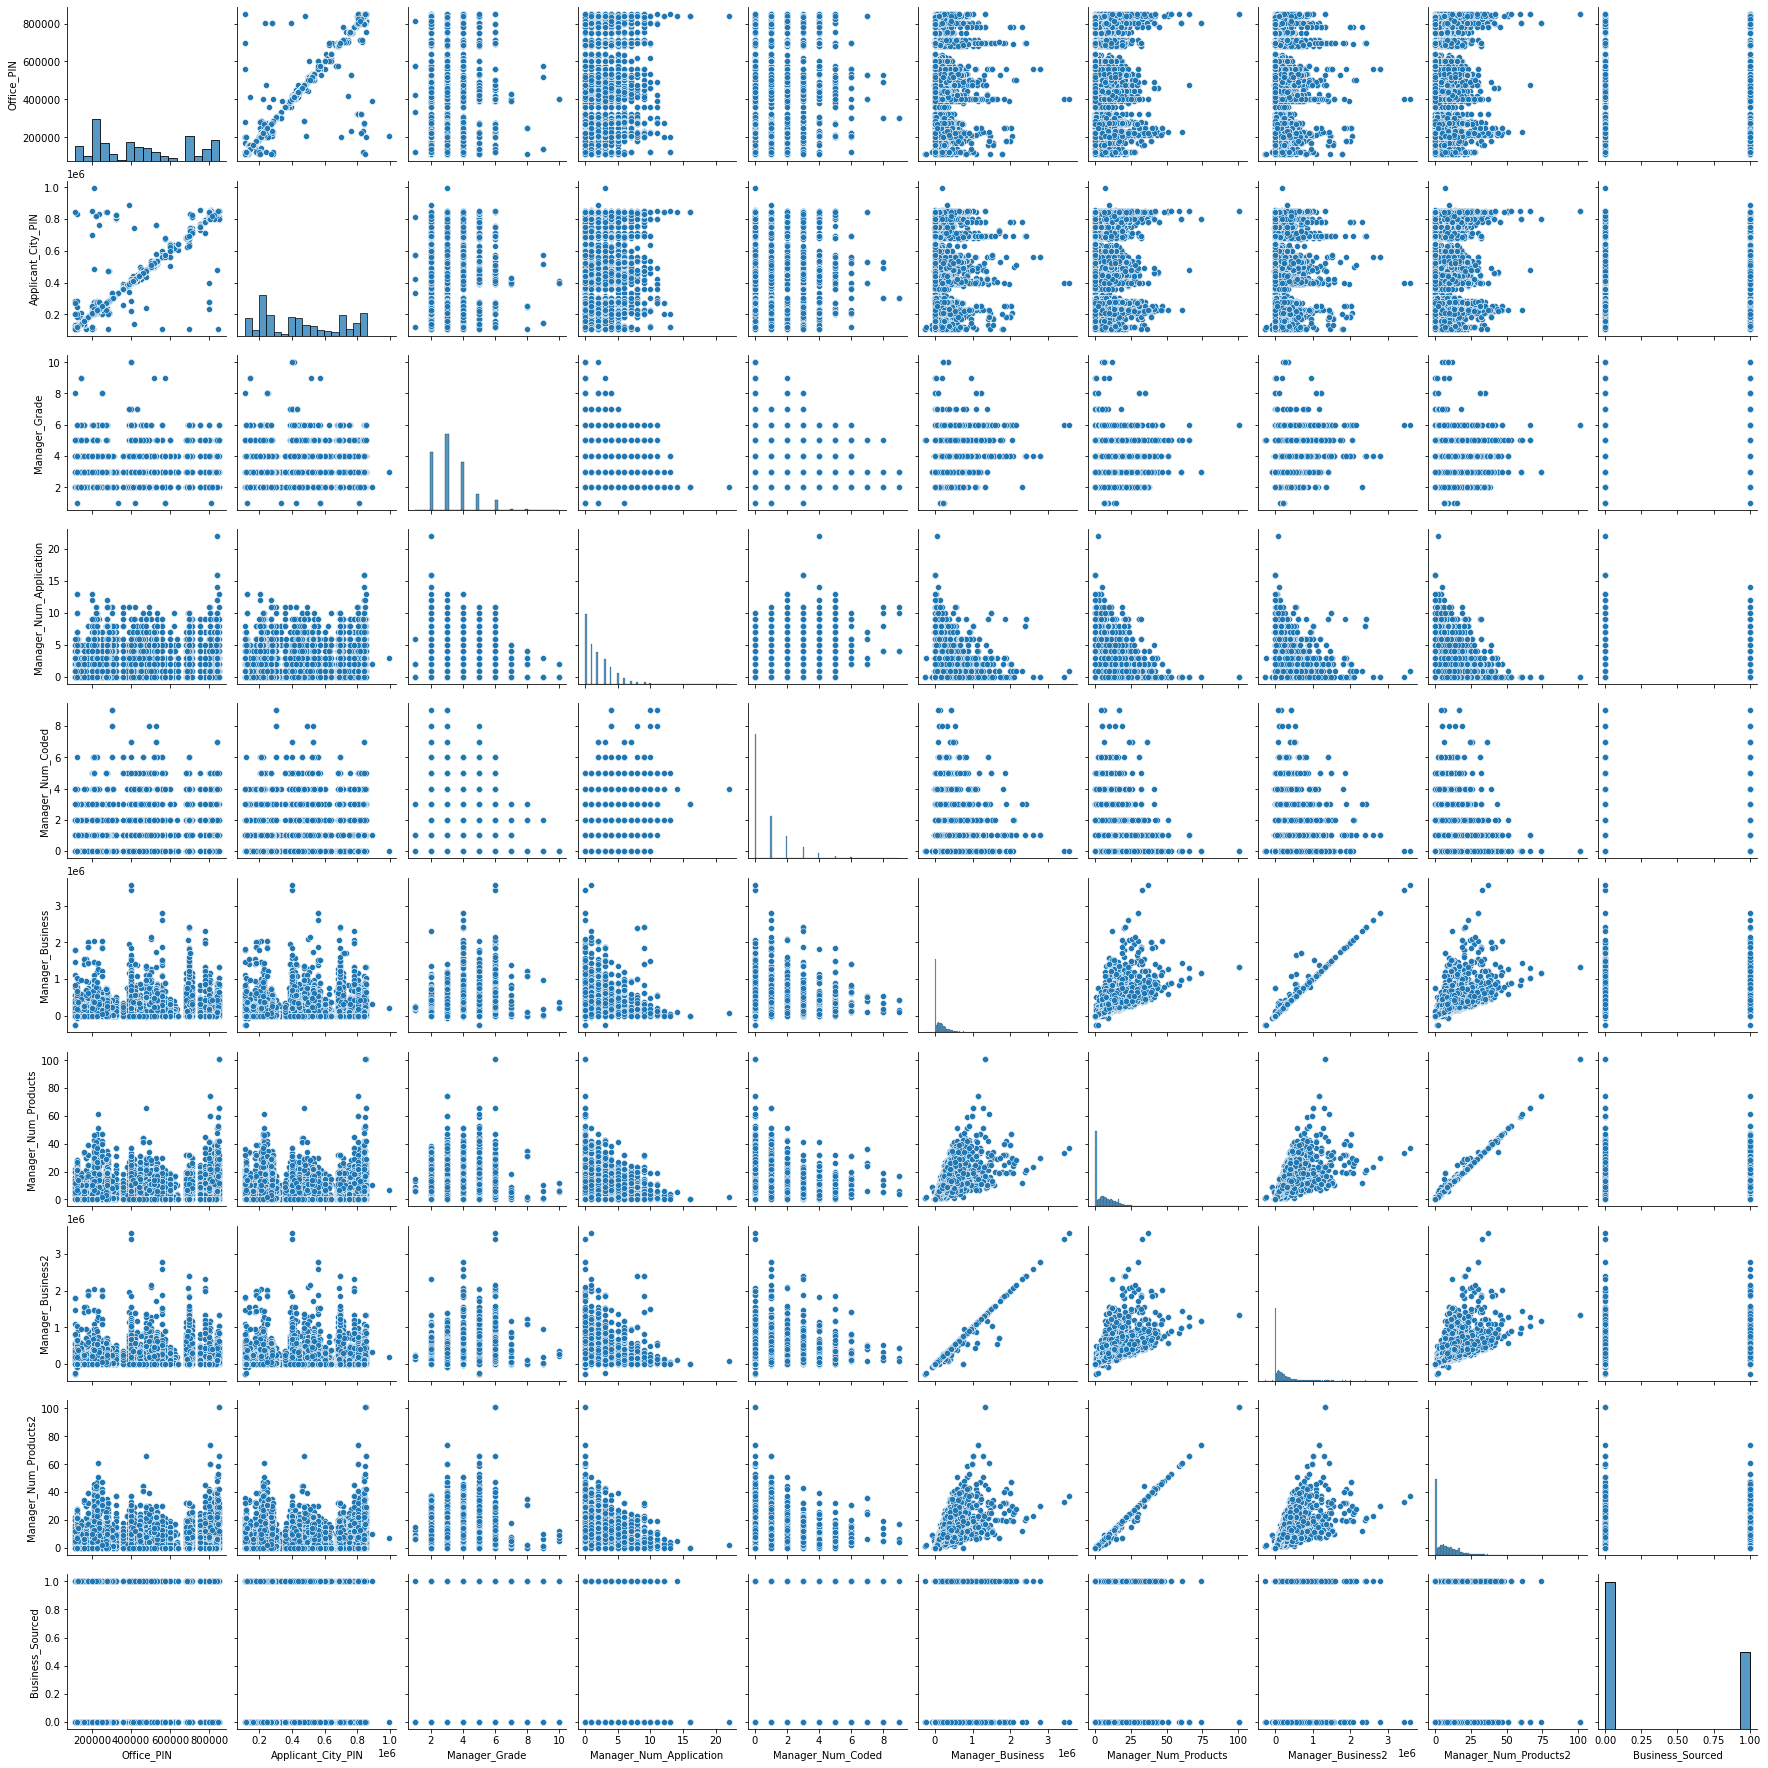

In [18]:
sns.pairplot(data = train_set)

Let's note here that there are some linear-like relationships between Manager_Business and Num_Products. Also, for a large number of points, Num_Products and Num_Products_2 are equivalent, which means we can probably drop one of those sets of columns. Lastly, it is very curious that such a large portion of the managers do not conduct business. However, it may simply be that they are non technical managers, i.e. they're function is only to manage people and not work as a technical lead, so it is not determinable whether these are incorrectly populated values.

<AxesSubplot:>

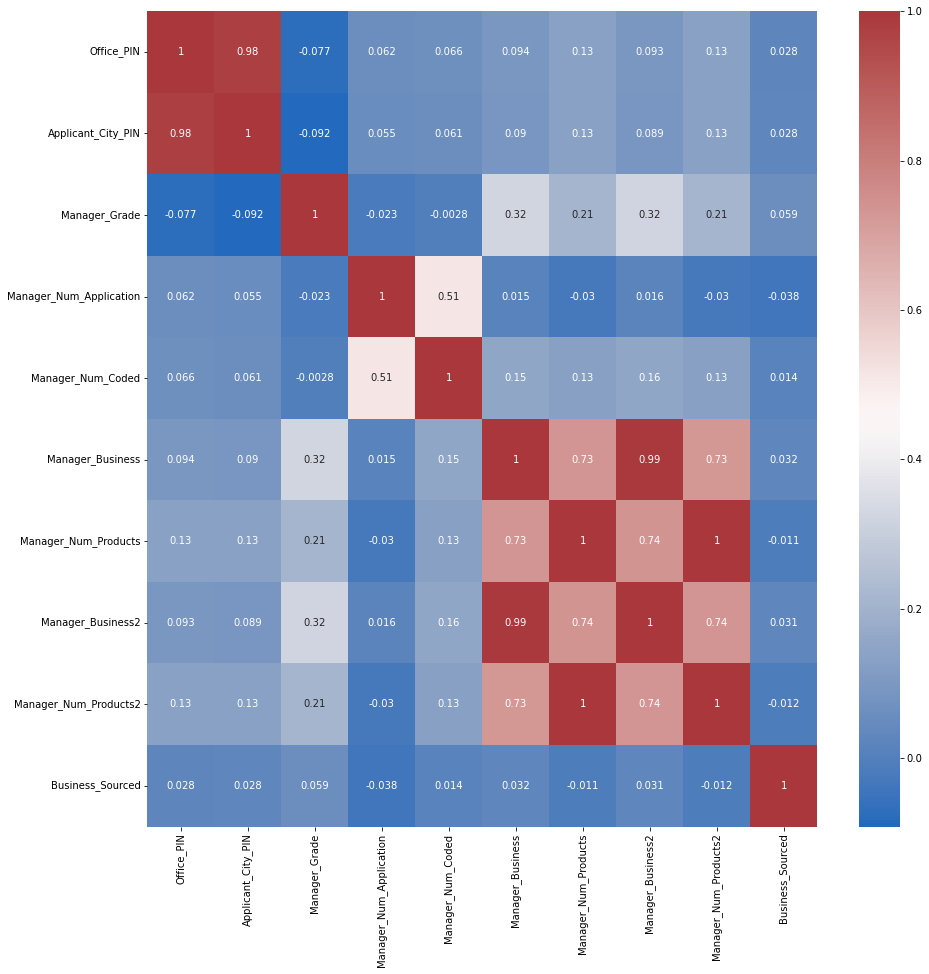

In [19]:
plt.figure(figsize = (15,15))
sns.heatmap(data = train_set.corr(), annot = True, cmap = 'vlag')

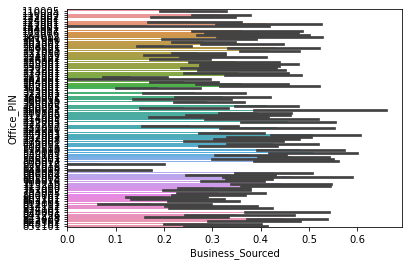

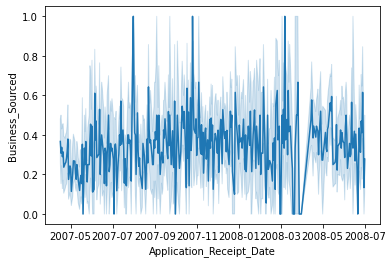

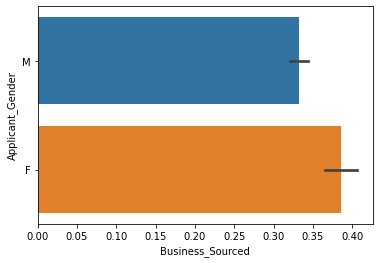

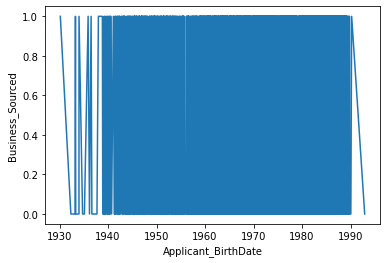

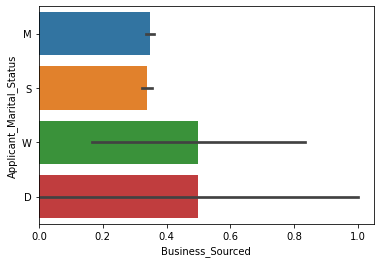

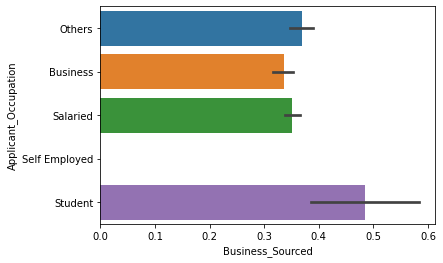

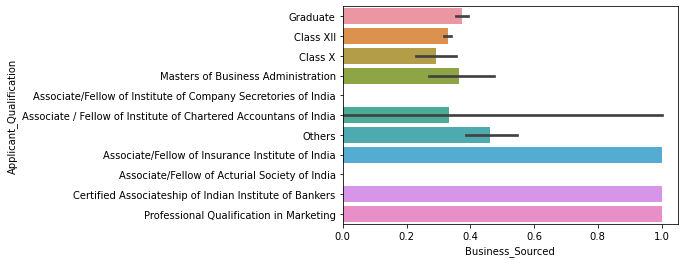

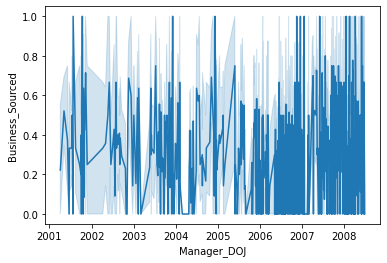

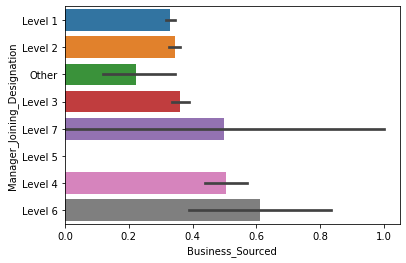

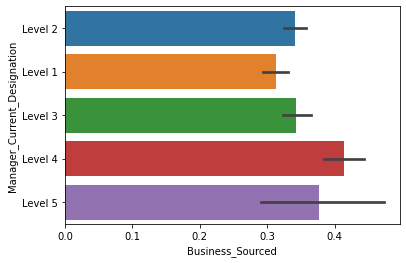

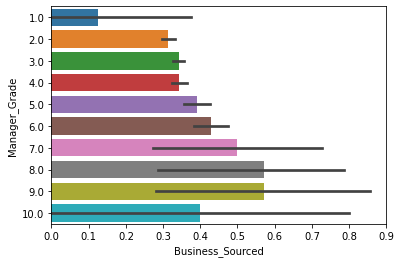

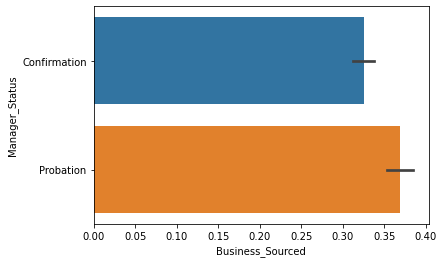

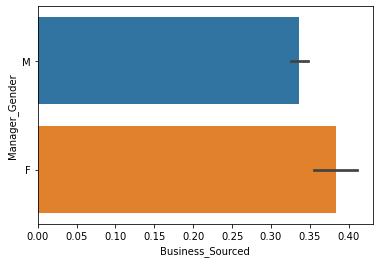

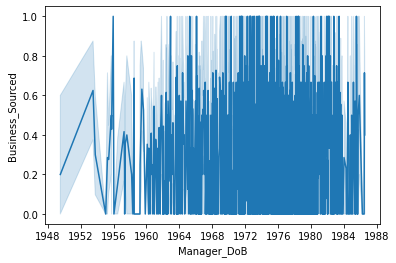

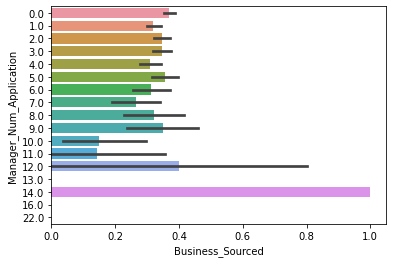

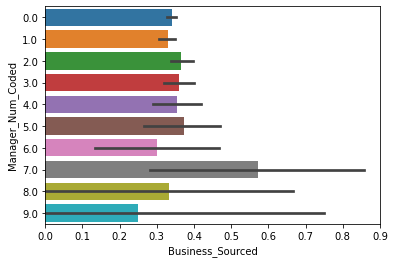

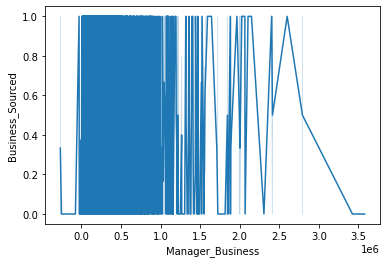

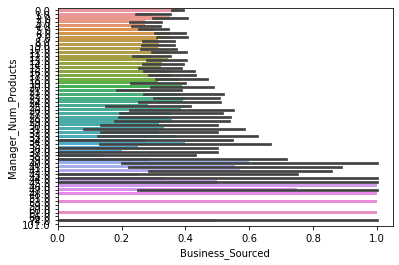

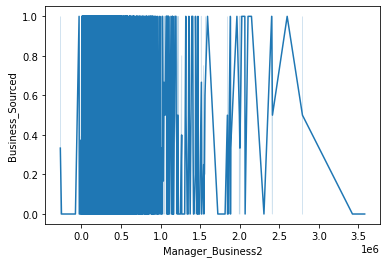

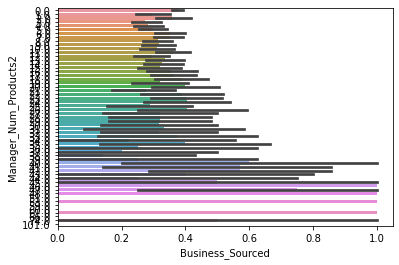

In [76]:
exclude = ['ID', 'Business_Sourced', 'Applicant_BirthDate', 'Applicant_City_PIN'] 
continuous = ['Application_Receipt_Date',  'Applicant_BirthDate', 'Manager_DOJ',
        'Manager_DoB','Manager_Business', 'Manager_Business2']
for column in train_set:
    if column not in continuous and column not in exclude:
        sns.barplot(data = train_set, x = train_set_targ, y = column, orient = 'h')
    elif column in continuous:
        sns.lineplot(data = train_set, y = train_set_targ, x = column)
    plt.show()
        

## Imputing Missing Values

In [20]:
train_set.columns

Index(['ID', 'Office_PIN', 'Application_Receipt_Date', 'Applicant_City_PIN',
       'Applicant_Gender', 'Applicant_BirthDate', 'Applicant_Marital_Status',
       'Applicant_Occupation', 'Applicant_Qualification', 'Manager_DOJ',
       'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Gender', 'Manager_DoB',
       'Manager_Num_Application', 'Manager_Num_Coded', 'Manager_Business',
       'Manager_Num_Products', 'Manager_Business2', 'Manager_Num_Products2',
       'Business_Sourced'],
      dtype='object')

Okay, first we'll use the column list to create two new data structures on which to begin modifying our original data as part of the cleaning process. We will forego including columns Applicant_City_PIN, Applicant_Gender, Applicant_BirthDate, Applicant_Marital_Status, Manager_Gender, and Manager_DoB for ethical reasons. We may however use them to construct additional features post-baseline modeling in concurrence with some of the other features. It could be interesting to include them in the classifier, because, should any of them prove useful as a metric, the best takeaway from that conclusion would be that the business has ethical concerns affecting agent success that need to be addressed. In the interest of making the most general model, we choose not to include them here. Similarly, while not as much of an ethical concern, Office_Pin and Applicant_Receipt_Date do not seem like they should inform the prediction in any way. It is possible that some offices perform better than others, and that the environment influencing success was different for each candidate based on their start date and work location, but again, if this is the case, it would lead to a lack of generality in the model and would indicate a concern to be addressed internally, so these columns are also not included. Finally, since it is just a unique identifier, ID is not included.

In [21]:
train_set_predictors = train_set[['Applicant_Occupation', 'Applicant_Qualification', 
       'Manager_DOJ', 'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Num_Application',
       'Manager_Num_Coded', 'Manager_Business', 'Manager_Num_Products',
       'Manager_Business2', 'Manager_Num_Products2']].copy()
train_set_targ = train_set['Business_Sourced'].copy()
test_predictors = test_set[['Applicant_Occupation', 'Applicant_Qualification', 'Manager_DOJ',
       'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Num_Application',
       'Manager_Num_Coded', 'Manager_Business', 'Manager_Num_Products',
       'Manager_Business2', 'Manager_Num_Products2']].copy()
ID_col = test_set['ID'].copy()

In [22]:
train_set_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Applicant_Occupation         8306 non-null   object        
 1   Applicant_Qualification      9441 non-null   object        
 2   Manager_DOJ                  8844 non-null   datetime64[ns]
 3   Manager_Joining_Designation  8844 non-null   object        
 4   Manager_Current_Designation  8844 non-null   object        
 5   Manager_Grade                8844 non-null   float64       
 6   Manager_Status               8844 non-null   object        
 7   Manager_Num_Application      8844 non-null   float64       
 8   Manager_Num_Coded            8844 non-null   float64       
 9   Manager_Business             8844 non-null   float64       
 10  Manager_Num_Products         8844 non-null   float64       
 11  Manager_Business2            8844 non-null 

In [23]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Applicant_Occupation         4041 non-null   object        
 1   Applicant_Qualification      5001 non-null   object        
 2   Manager_DOJ                  4221 non-null   datetime64[ns]
 3   Manager_Joining_Designation  4221 non-null   object        
 4   Manager_Current_Designation  4221 non-null   object        
 5   Manager_Grade                4221 non-null   float64       
 6   Manager_Status               4221 non-null   object        
 7   Manager_Num_Application      4221 non-null   float64       
 8   Manager_Num_Coded            4221 non-null   float64       
 9   Manager_Business             4221 non-null   float64       
 10  Manager_Num_Products         4221 non-null   float64       
 11  Manager_Business2            4221 non-null 

Now, to make some changes. Let's prepare the remaining columns for OHE or label encoding, depending on the column. First, we will replace all of the NaNs in the non-ordinal categories with 'Unknown'.

In [24]:
for column in train_set_predictors.columns:
    if train_set_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         3787
Business         2303
Others           1966
NaN              1221
Self Employed     149
Student           101
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Class XII                                                           5806
Graduate                                                            3196
Class X                                                              225
Others                                                               132
NaN                                                                   86
Masters of Business Administration                                    74
Associate / Fellow of Institute of Chartered Accountans of India       3
Associate/Fellow of Institute of Company Secretories of India          1
Associate/Fellow of Insurance Institute of India                       1
Associate/Fellow of Acturial Society of India                          1
Certified Associateship of

In [25]:
for column in test_predictors.columns:
    if test_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         2560
NaN              1004
Business          646
Others            506
Self Employed     310
Student            19
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Graduate                                                                              3375
Class XII                                                                             1357
Others                                                                                 171
Masters of Business Administration                                                      71
NaN                                                                                     44
Class X                                                                                 19
Professional Qualification in Marketing                                                  5
Associate / Fellow of Institute of Chartered Accountans of India                         2
Associate/Fellow of Institut

There are pretty large numbers of NaNs in some of these columns.. not great. Anyway, let's work with the non-ordinal categories, first replacing the NaNs with unknown, then binning some of the smaller groups into 'Other'. 

In [26]:
non_ordinal = ['Applicant_Occupation', 'Applicant_Qualification', 'Manager_Status']
for column in non_ordinal:
    train_set_predictors[column] = train_set_predictors[column].fillna(value = 'Unknown')
    test_predictors[column] = test_predictors[column].fillna(value = 'Unknown')

In [27]:
train_set_predictors.Applicant_Qualification.value_counts()[train_set_predictors.Applicant_Qualification.value_counts() <= 10].index

Index(['Associate / Fellow of Institute of Chartered Accountans of India',
       'Associate/Fellow of Institute of Company Secretories of India',
       'Associate/Fellow of Insurance Institute of India',
       'Associate/Fellow of Acturial Society of India',
       'Certified Associateship of Indian Institute of Bankers',
       'Professional Qualification in Marketing'],
      dtype='object')

In [28]:
for column in non_ordinal:
    for category in train_set_predictors[column].value_counts()[train_set_predictors[column].value_counts() <= 10].index:
        train_set_predictors[column] = train_set_predictors[column].str.replace(category,'Professional Fellow')
    for category in test_predictors[column].value_counts()[test_predictors[column].value_counts() <= 10].index:
        test_predictors[column] = test_predictors[column].str.replace(category,'Professional Fellow')

In [29]:
for column in train_set_predictors.columns:
    if train_set_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         3787
Business         2303
Others           1966
Unknown          1221
Self Employed     149
Student           101
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Class XII                             5806
Graduate                              3196
Class X                                225
Others                                 132
Unknown                                 86
Masters of Business Administration      74
Professional Fellow                      8
Name: Applicant_Qualification, dtype: int64
Column Name: Manager_Joining_Designation
Level 1    4632
Level 2    2787
Level 3    1146
NaN         683
Level 4     200
Other        58
Level 6      18
Level 7       2
Level 5       1
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 2    3208
Level 1    2479
Level 3    2033
Level 4    1031
NaN         683
Level 5      93
Name: Manager_Current_Designation, dtype:

In [30]:
for column in test_predictors.columns:
    if test_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Applicant_Occupation
Salaried         2560
Unknown          1004
Business          646
Others            506
Self Employed     310
Student            19
Name: Applicant_Occupation, dtype: int64
Column Name: Applicant_Qualification
Graduate                              3375
Class XII                             1357
Others                                 171
Masters of Business Administration      71
Unknown                                 44
Class X                                 19
Professional Fellow                      8
Name: Applicant_Qualification, dtype: int64
Column Name: Manager_Joining_Designation
Level 2    1441
Level 3    1337
Level 1    1217
NaN         824
Level 4     208
Level 5      15
Level 6       3
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 3    1530
Level 2    1440
Level 1     887
NaN         824
Level 4     334
Level 5      30
Name: Manager_Current_Designation, dtype: int64
Column Name: Manager_Stat

Okay, looks like it worked! Now let's dummy encode them as the last step.

In [31]:
for column in non_ordinal:
#     drop_cat = train_set_predictors[column].value_counts().index[0]
    dummies_train = pd.get_dummies(train_set_predictors[column], prefix = column)
    dummies_test = pd.get_dummies(test_predictors[column], prefix = column)
    train_set_predictors = pd.concat([train_set_predictors, dummies_train], axis = 1)
    test_predictors = pd.concat([test_predictors, dummies_test], axis = 1)
    train_set_predictors.drop(columns = [column], inplace = True) #, column + '_' + drop_cat], inplace = True)
    test_predictors.drop(columns = [column], inplace = True) #, column + '_' + drop_cat], inplace = True)

In [32]:
train_set_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Manager_DOJ                                                 8844 non-null   datetime64[ns]
 1   Manager_Joining_Designation                                 8844 non-null   object        
 2   Manager_Current_Designation                                 8844 non-null   object        
 3   Manager_Grade                                               8844 non-null   float64       
 4   Manager_Num_Application                                     8844 non-null   float64       
 5   Manager_Num_Coded                                           8844 non-null   float64       
 6   Manager_Business                                            8844 non-null   float64       
 7   Manager_Num_Products    

In [33]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Manager_DOJ                                                 4221 non-null   datetime64[ns]
 1   Manager_Joining_Designation                                 4221 non-null   object        
 2   Manager_Current_Designation                                 4221 non-null   object        
 3   Manager_Grade                                               4221 non-null   float64       
 4   Manager_Num_Application                                     4221 non-null   float64       
 5   Manager_Num_Coded                                           4221 non-null   float64       
 6   Manager_Business                                            4221 non-null   float64       
 7   Manager_Num_Products    

Now, let's deal with the ordinal columns. The ordinal columns present a unique challenge because, where do we put unknowns in the ranking? They are large enough portions of the dataset that it presents concerns with skewing the original data in bias by random chance with improper imputation methods. Imputing either the mean or mode seems like it will almost definitely cause this to happen, so I think the best method is frequency based random imputation, at least to start. Now, we must remember that we should use the training data frequencies to impute values into the test set, because we fit our transformation on the training set, not the test set. Also, since other is meaningless in this context and there are very few of them, let's replace Other with NaNs that will then be randomly distributed to the other levels.

In [34]:
ordinal = ['Manager_Joining_Designation','Manager_Current_Designation']
rng = np.random.default_rng(4)
for column in ordinal:
    train_set_predictors[column] = train_set_predictors[column].replace('Other',np.nan)
    freqs = train_set_predictors[column].value_counts(normalize = True)
    train_set_predictors.loc[train_set_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = train_set_predictors[column].isna().sum())
    test_predictors.loc[test_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = test_predictors[column].isna().sum())

In [35]:
for column in train_set_predictors.columns:
    if train_set_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(train_set_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Manager_Joining_Designation
Level 1    5008
Level 2    3029
Level 3    1255
Level 4     213
Level 6      19
Level 7       2
Level 5       1
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 2    3453
Level 1    2674
Level 3    2183
Level 4    1121
Level 5      96
Name: Manager_Current_Designation, dtype: int64


In [36]:
for column in test_predictors.columns:
    if test_predictors[column].dtype == 'object':
        print('=================================')
        print(f'Column Name: {column}')
        print(test_predictors[column].value_counts(dropna = False))
        print('=================================')

Column Name: Manager_Joining_Designation
Level 2    1697
Level 1    1662
Level 3    1439
Level 4     226
Level 5      15
Level 6       6
Name: Manager_Joining_Designation, dtype: int64
Column Name: Manager_Current_Designation
Level 2    1728
Level 3    1717
Level 1    1125
Level 4     436
Level 5      39
Name: Manager_Current_Designation, dtype: int64


Okay, looks good on that front. Now, lets encode them using OrdinalEncoder.

In [37]:
ordenc = OrdinalEncoder()
ordenc.fit(train_set_predictors[ordinal])
ordenc.categories_

[array(['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5', 'Level 6',
        'Level 7'], dtype=object),
 array(['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'],
       dtype=object)]

In [38]:
train_set_predictors[ordinal] = ordenc.transform(train_set_predictors[ordinal])
test_predictors[ordinal] = ordenc.transform(test_predictors[ordinal])

In [39]:
train_set_predictors['Manager_Joining_Designation'].value_counts()

0.0    5008
1.0    3029
2.0    1255
3.0     213
5.0      19
6.0       2
4.0       1
Name: Manager_Joining_Designation, dtype: int64

In [40]:
test_predictors['Manager_Joining_Designation'].value_counts()

1.0    1697
0.0    1662
2.0    1439
3.0     226
4.0      15
5.0       6
Name: Manager_Joining_Designation, dtype: int64

Okay! Looking solid. Now let's move on to missing values for our other columns, the ones that were our original numeric columns. I suspect some of them, based on the column names and provided info, are already label encoded or ordinal categories, so let's look at value_counts real quick.

In [41]:
remaining_cols = ['Manager_DOJ','Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Business','Manager_Num_Products','Manager_Business2','Manager_Num_Products2']
for column in remaining_cols:
    print('=================================')
    print(f'Column Name: {column}')
    print("Train Counts:")
    print(train_set_predictors[column].value_counts(dropna = False))
    print("Test Counts:")
    print(test_predictors[column].value_counts(dropna = False))
    print('=================================')

Column Name: Manager_DOJ
Train Counts:
NaT           683
2007-07-09    106
2007-06-11     76
2007-11-06     71
2006-05-08     69
             ... 
2004-12-15      1
2008-02-14      1
2006-11-17      1
2007-01-15      1
2007-09-25      1
Name: Manager_DOJ, Length: 647, dtype: int64
Test Counts:
NaT           824
2008-08-04    150
2008-10-02    107
2008-06-02     89
2008-07-02     69
             ... 
2008-03-31      1
2007-11-14      1
2006-07-01      1
2008-02-15      1
2006-01-14      1
Name: Manager_DOJ, Length: 466, dtype: int64
Column Name: Manager_Grade
Train Counts:
3.0     3207
2.0     2471
4.0     2038
NaN      683
5.0      666
6.0      406
7.0       22
8.0       14
1.0        8
9.0        7
10.0       5
Name: Manager_Grade, dtype: int64
Test Counts:
4.0    1507
3.0    1445
2.0     905
NaN     824
5.0     220
6.0     132
7.0       9
8.0       3
Name: Manager_Grade, dtype: int64
Column Name: Manager_Num_Application
Train Counts:
0.0     2980
1.0     1677
2.0     1339
3.0     107

For these, we can impute values for the NaNs by the same treatment, random frequency based replacement, as we did for the ordinal columns above. These columns seem discrete enough. We may also be able to turn DOJ into a more easily understood column, such as tenure in month or years, to which that can also be applied. Let's start with replacing the DOJ column with tenure. I am also noting here that, in the future, there may be a better, more time consuming implementation for imputation for columns such as the Manager Num Products, Business, and the second column for each of those, as in the scatter plots above there is a somewhat linear relationship between these variables, enough so that a regression based or iterative imputer might be more effective.

In [42]:
train_set_predictors['Manager_DOJ'].dt.year.value_counts()

2007.0    3286
2006.0    2043
2008.0     954
2003.0     820
2004.0     638
2005.0     521
2001.0     294
2002.0     288
Name: Manager_DOJ, dtype: int64

Years since joining seems like a fine enough way to bin them.

In [43]:
train_set_predictors['Manager_YOJ'] = train_set_predictors['Manager_DOJ'].dt.year
test_predictors['Manager_YOJ'] = test_predictors['Manager_DOJ'].dt.year

In [44]:
train_set_predictors['Manager_YOJ'].value_counts(dropna = False)

2007.0    3286
2006.0    2043
2008.0     954
2003.0     820
NaN        683
2004.0     638
2005.0     521
2001.0     294
2002.0     288
Name: Manager_YOJ, dtype: int64

In [45]:
train_set_predictors = train_set_predictors.drop(columns = ['Manager_DOJ'])
test_predictors = test_predictors.drop(columns = ['Manager_DOJ'])

In [46]:
PMF_cols = ['Manager_YOJ','Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Business','Manager_Num_Products','Manager_Business2','Manager_Num_Products2']
for column in PMF_cols:
    freqs = train_set_predictors[column].value_counts(normalize = True)
    train_set_predictors.loc[train_set_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = train_set_predictors[column].isna().sum())
    test_predictors.loc[test_predictors[column].isna(), column] = rng.choice(
        freqs.index, p = freqs.values, size = test_predictors[column].isna().sum())

In [47]:
remaining_cols = ['Manager_YOJ','Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Business','Manager_Num_Products','Manager_Business2','Manager_Num_Products2']
for column in remaining_cols:
    print('=================================')
    print(f'Column Name: {column}')
    print("Train Counts:")
    print(train_set_predictors[column].value_counts(dropna = False))
    print("Test Counts:")
    print(test_predictors[column].value_counts(dropna = False))
    print('=================================')

Column Name: Manager_YOJ
Train Counts:
2007.0    3528
2006.0    2198
2008.0    1023
2003.0     890
2004.0     687
2005.0     567
2001.0     320
2002.0     314
Name: Manager_YOJ, dtype: int64
Test Counts:
2008.0    2652
2007.0     833
2006.0     573
2003.0     345
2004.0     248
2005.0     185
2002.0     119
2001.0      90
Name: Manager_YOJ, dtype: int64
Column Name: Manager_Grade
Train Counts:
3.0     3473
2.0     2636
4.0     2200
5.0      714
6.0      437
7.0       29
8.0       14
1.0        9
9.0        9
10.0       6
Name: Manager_Grade, dtype: int64
Test Counts:
3.0    1718
4.0    1694
2.0    1171
5.0     277
6.0     171
7.0      10
8.0       3
1.0       1
Name: Manager_Grade, dtype: int64
Column Name: Manager_Num_Application
Train Counts:
0.0     3213
1.0     1793
2.0     1452
3.0     1161
4.0      756
5.0      503
6.0      292
7.0      142
8.0       90
9.0       66
10.0      27
11.0      15
16.0       6
12.0       5
13.0       4
14.0       1
22.0       1
Name: Manager_Num_Applic

In [48]:
train_set_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Manager_Joining_Designation                                 9527 non-null   float64
 1   Manager_Current_Designation                                 9527 non-null   float64
 2   Manager_Grade                                               9527 non-null   float64
 3   Manager_Num_Application                                     9527 non-null   float64
 4   Manager_Num_Coded                                           9527 non-null   float64
 5   Manager_Business                                            9527 non-null   float64
 6   Manager_Num_Products                                        9527 non-null   float64
 7   Manager_Business2                                           9527 non-null   float64
 8 

In [49]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Manager_Joining_Designation                                 5045 non-null   float64
 1   Manager_Current_Designation                                 5045 non-null   float64
 2   Manager_Grade                                               5045 non-null   float64
 3   Manager_Num_Application                                     5045 non-null   float64
 4   Manager_Num_Coded                                           5045 non-null   float64
 5   Manager_Business                                            5045 non-null   float64
 6   Manager_Num_Products                                        5045 non-null   float64
 7   Manager_Business2                                           5045 non-null   float64
 8 

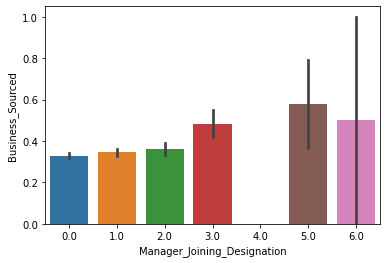

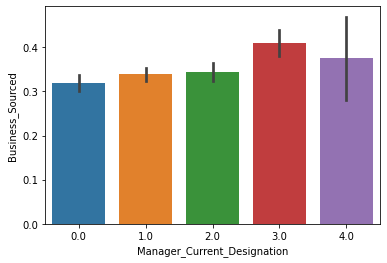

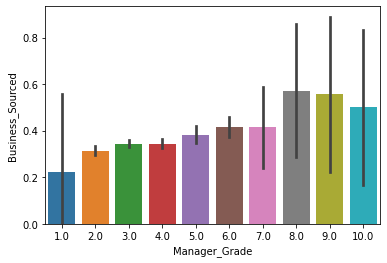

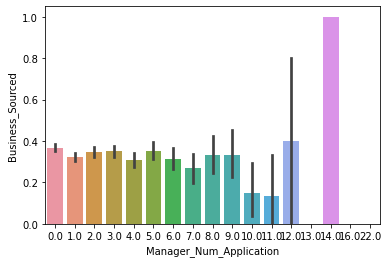

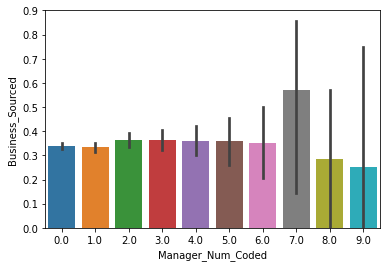

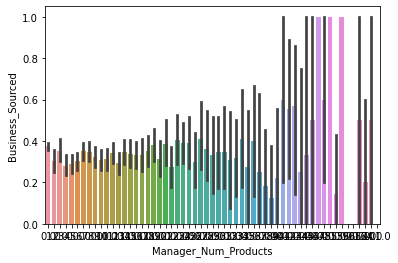

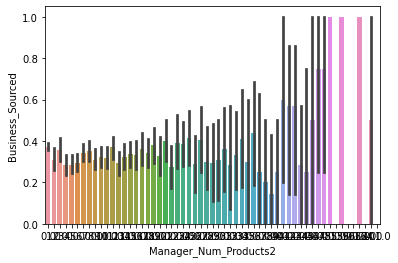

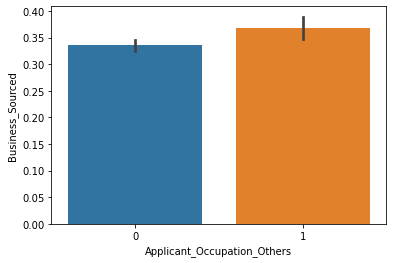

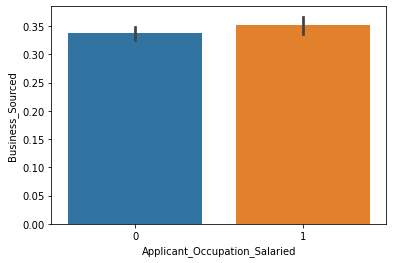

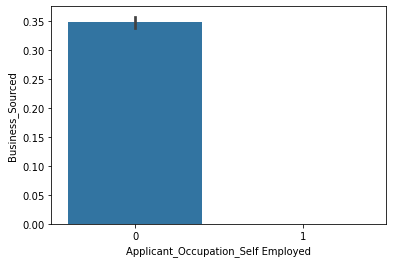

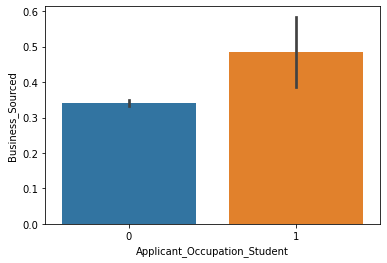

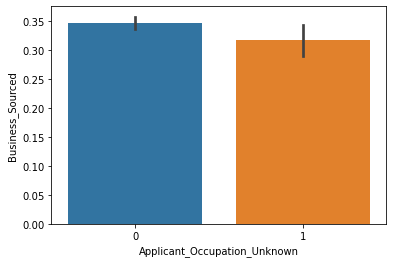

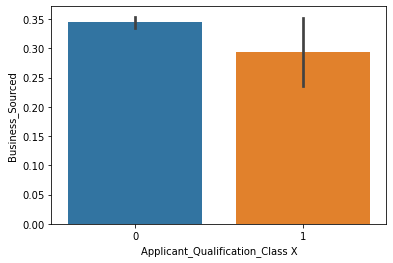

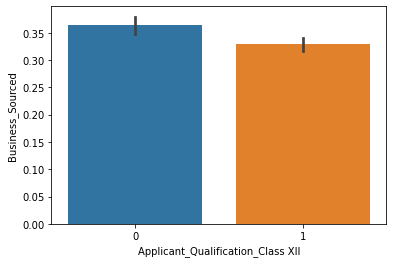

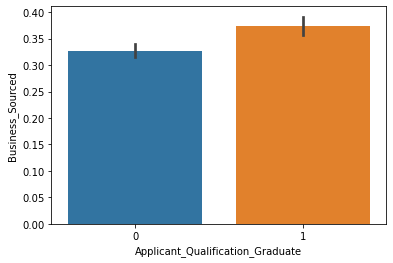

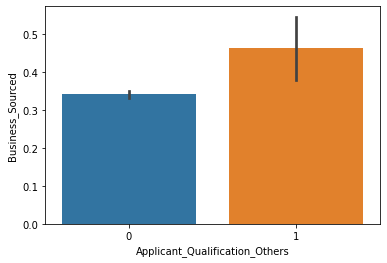

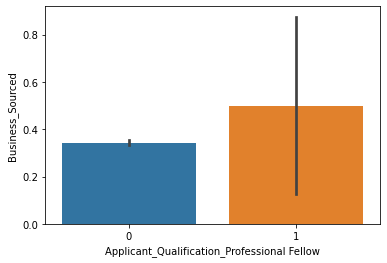

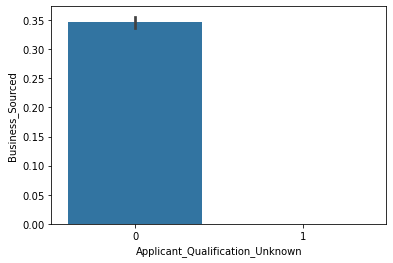

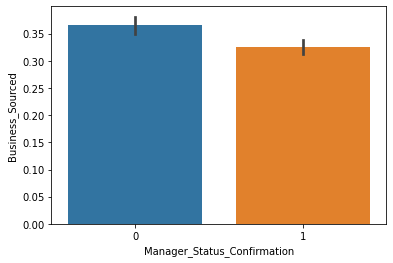

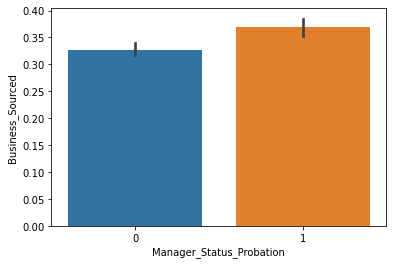

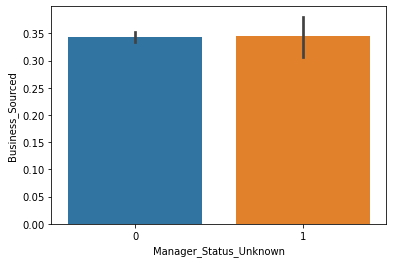

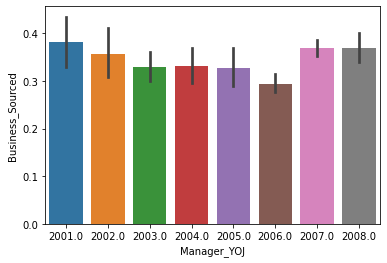

In [50]:
for column in train_set_predictors:
    if 'Business' not in column:
        sns.barplot(data = train_set_predictors, y = train_set_targ, x = column)
        plt.show()

<AxesSubplot:>

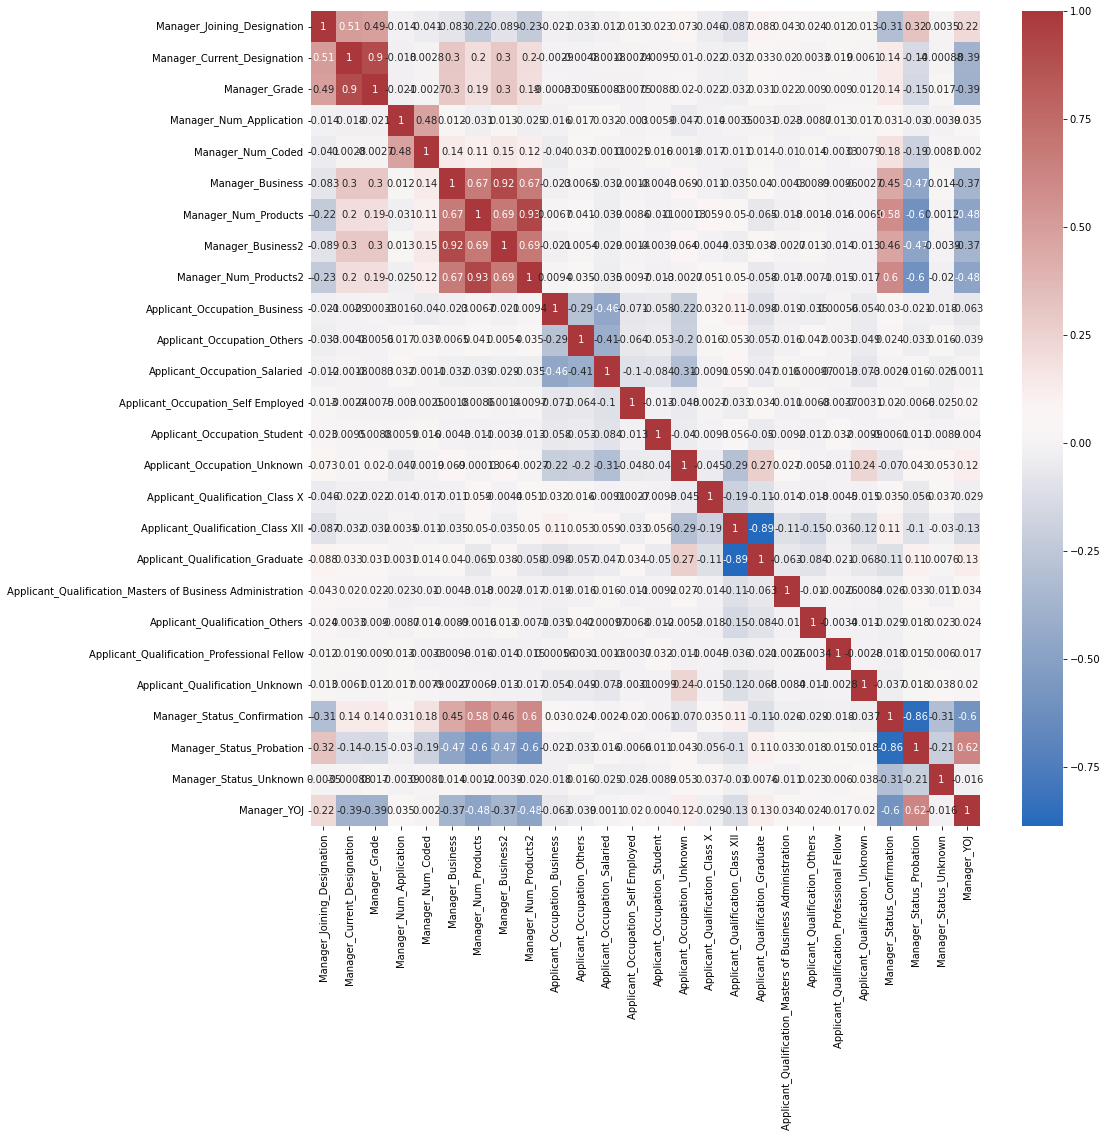

In [51]:
plt.figure(figsize = (15,15))
sns.heatmap(data = train_set_predictors.corr(), annot = True, cmap = 'vlag')

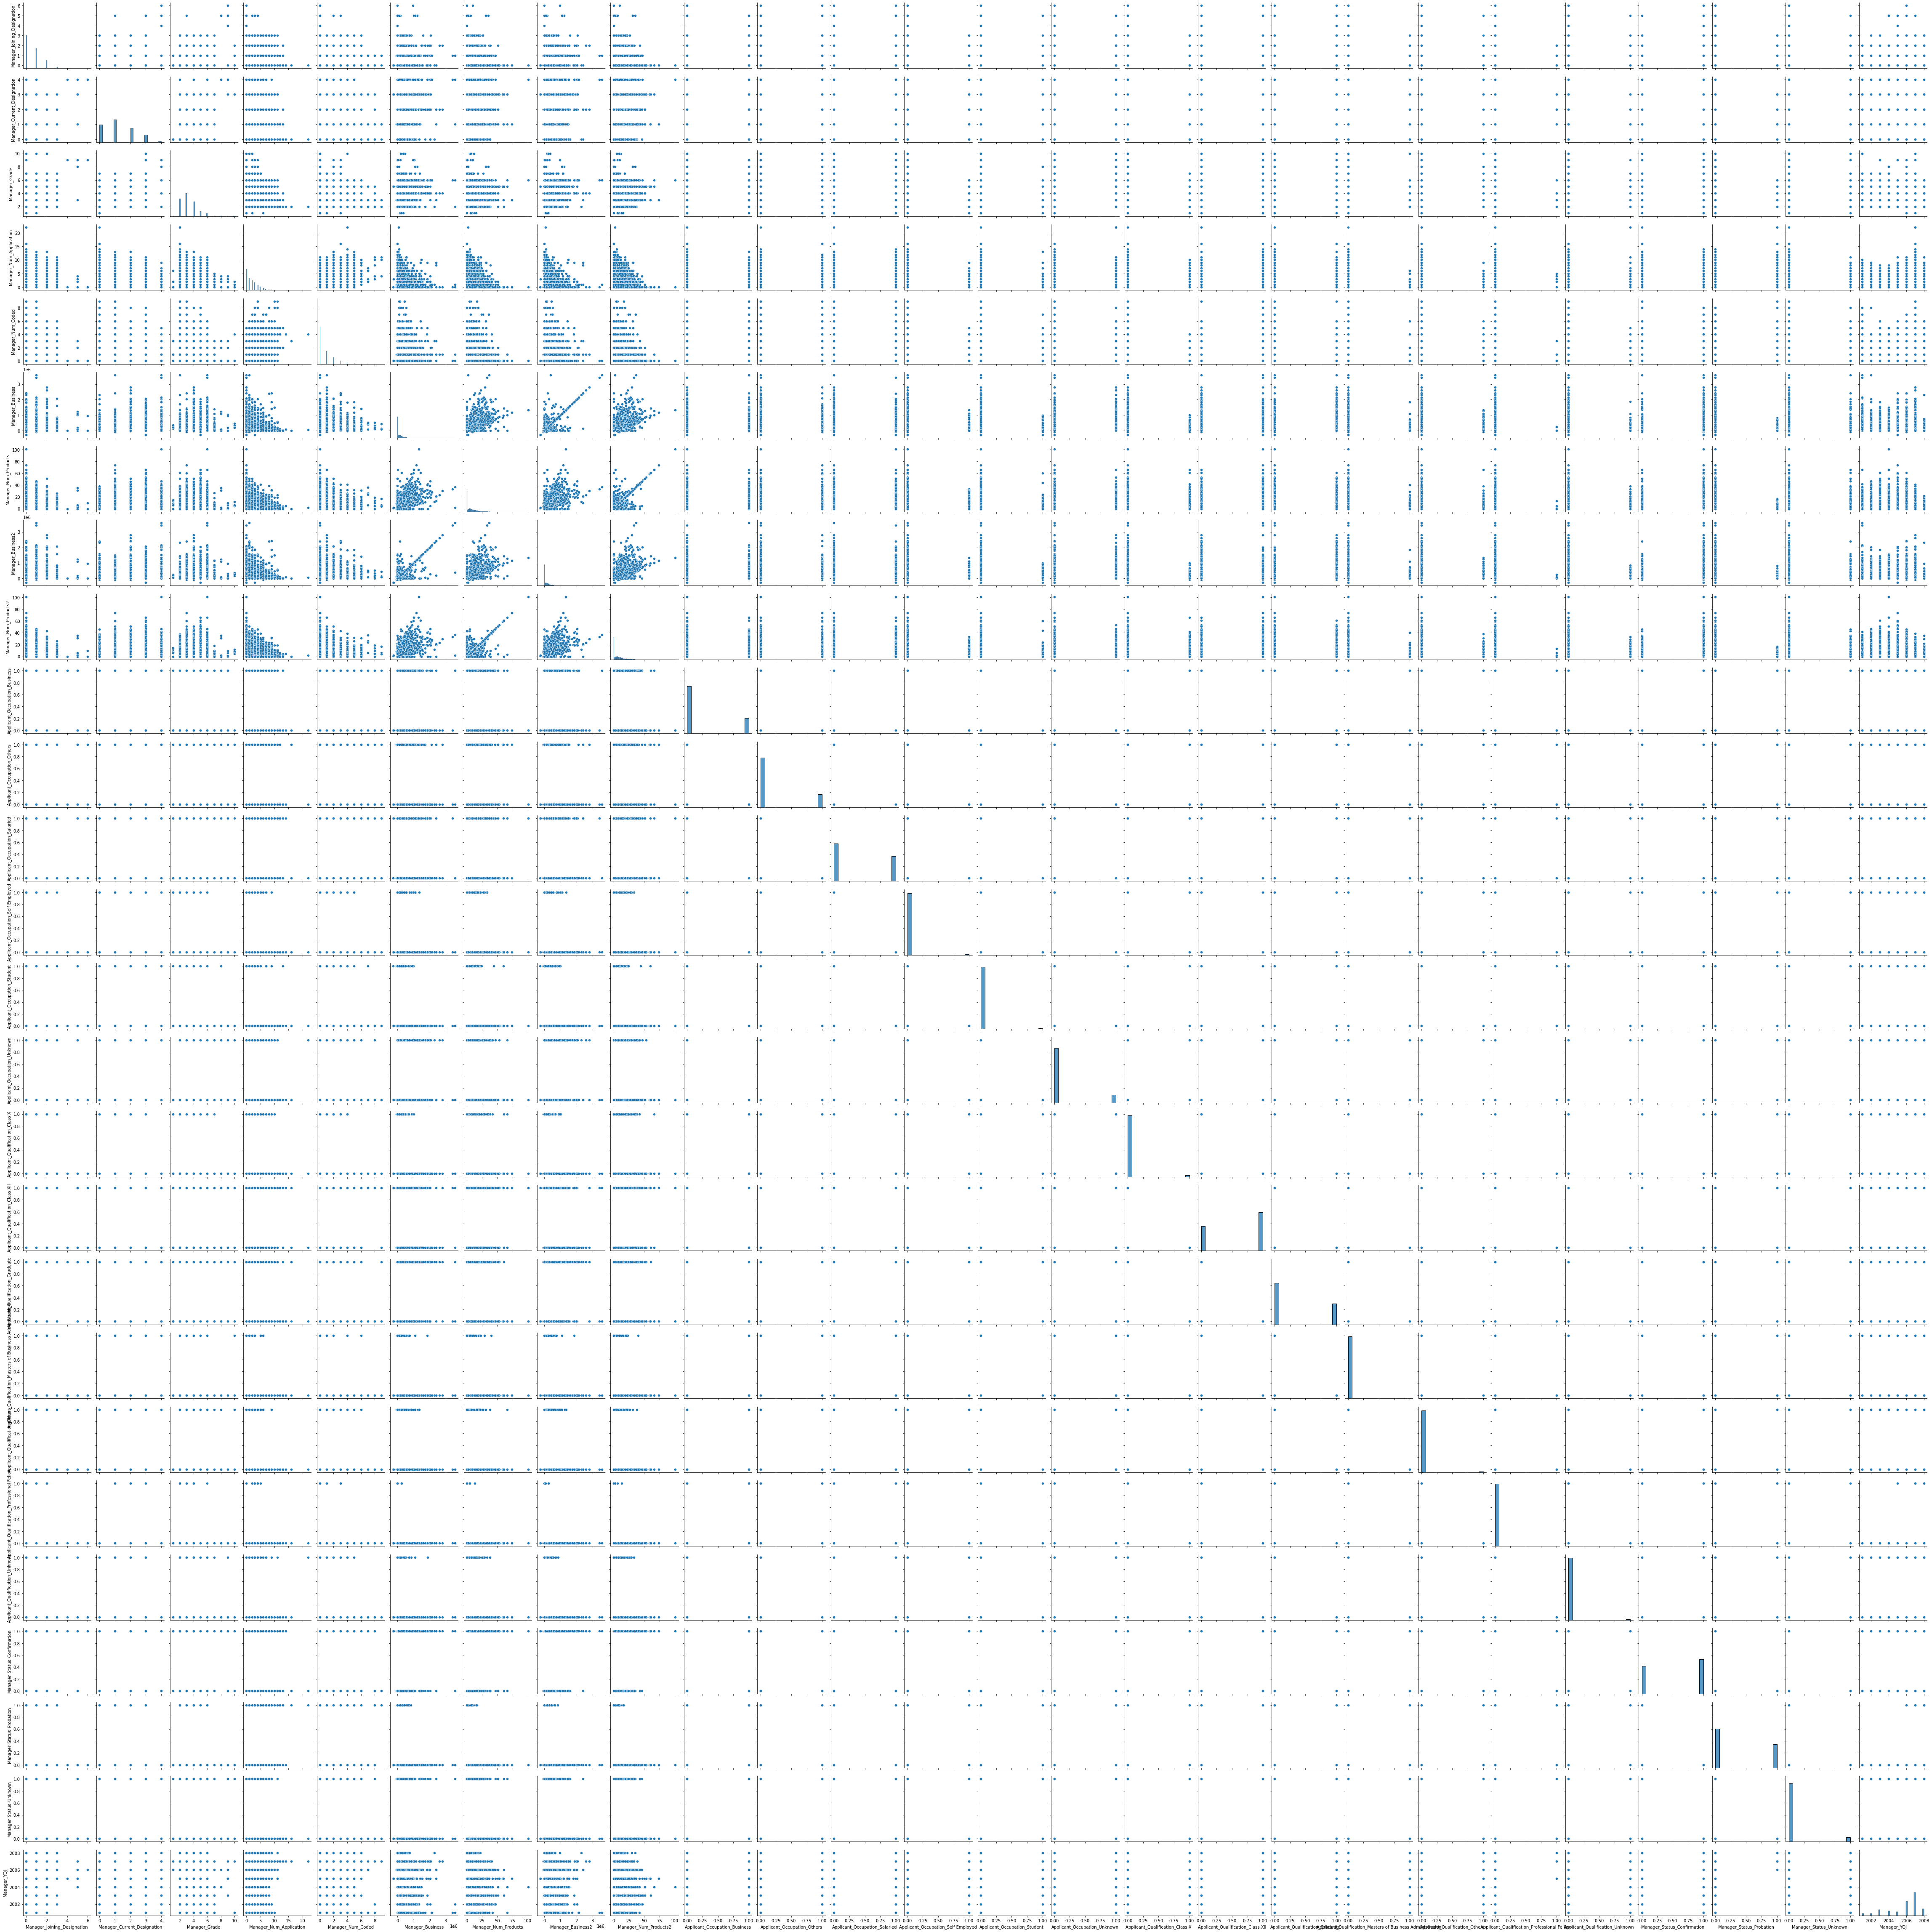

In [52]:
sns.pairplot(data = train_set_predictors)

Hmm.. I quickly want to investigate how many records actually have differing values between the business and num products columns.

In [53]:
(train_set_predictors.Manager_Num_Products != train_set_predictors.Manager_Num_Products2).sum()

636

In [54]:
(train_set_predictors.Manager_Num_Products > train_set_predictors.Manager_Num_Products2).sum()

342

Hmm.. like 6 or 7 percent? Doesn't feel like a significant amount. It is also confusing that, if 2 is the same as the regular minus products except the category A partner, why is it not always less than the regular? Maybe in the future, I'll add a feature for a binary is Num2 and Business2 different than the regular, but for now, I'll just drop the secondary columns.

In [55]:
train_set_predictors = train_set_predictors.drop(columns = ['Manager_Num_Products2','Manager_Business2'])
test_predictors = test_predictors.drop(columns = ['Manager_Num_Products2','Manager_Business2'])

Okay! We have dealt with all the missing values, prepared categorical features, and dropped lots of columns. Let's get into some baselines!

# Baseline Models

In [56]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [57]:
def evaluate_models(models,X,y):
    '''
    Takes in a list of tuples, where the tuples are a model name string and the model class.
    Adds models to a Pipeline, evaluates all models, displays relative graphs and prints
    scoring information.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
    
    pipelines = []
    for name, model in models:
        pipelines.append((name,Pipeline([(name,model)])))    
    
    for name, model in pipelines:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print('=================================================================================')
        print(f'Model Name: {name}')
        print(classification_report(y_test,y_pred))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(data = cm, annot = True)
        plot_roc_curve(model, X_test, y_test)
        plt.show()
        print('=================================================================================')

Model Name: LR
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1882
           1       1.00      0.00      0.00       977

    accuracy                           0.66      2859
   macro avg       0.83      0.50      0.40      2859
weighted avg       0.78      0.66      0.52      2859



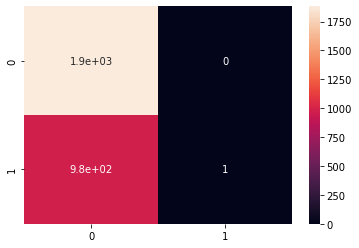

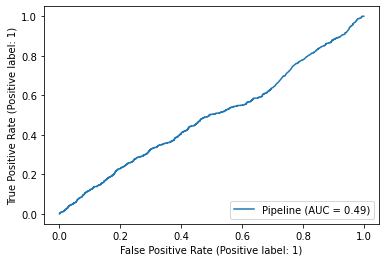

Model Name: LDA
              precision    recall  f1-score   support

           0       0.66      0.98      0.79      1882
           1       0.46      0.03      0.06       977

    accuracy                           0.66      2859
   macro avg       0.56      0.51      0.43      2859
weighted avg       0.59      0.66      0.54      2859



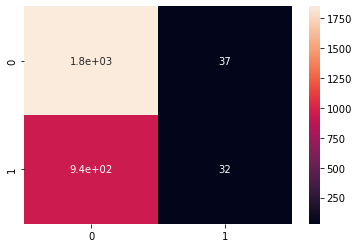

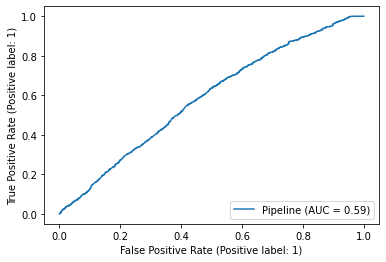

Model Name: KNN
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      1882
           1       0.38      0.26      0.31       977

    accuracy                           0.60      2859
   macro avg       0.53      0.52      0.52      2859
weighted avg       0.57      0.60      0.58      2859



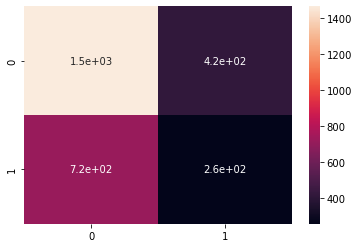

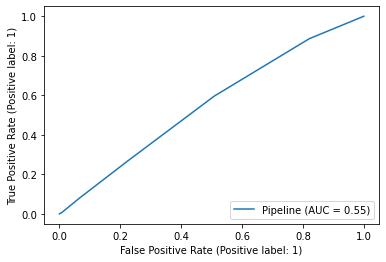

Model Name: CART
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1882
           1       0.39      0.33      0.35       977

    accuracy                           0.59      2859
   macro avg       0.53      0.53      0.53      2859
weighted avg       0.58      0.59      0.58      2859



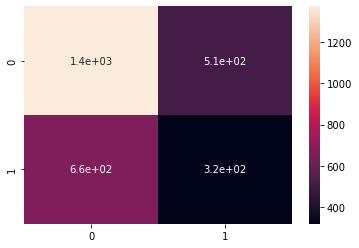

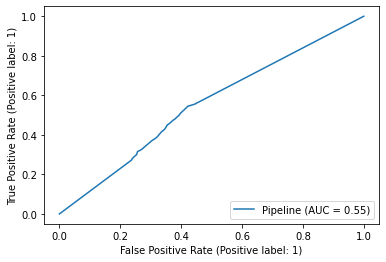

Model Name: NB
              precision    recall  f1-score   support

           0       0.66      0.97      0.79      1882
           1       0.39      0.04      0.07       977

    accuracy                           0.65      2859
   macro avg       0.53      0.50      0.43      2859
weighted avg       0.57      0.65      0.54      2859



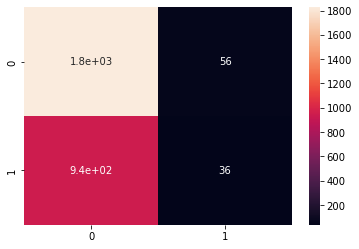

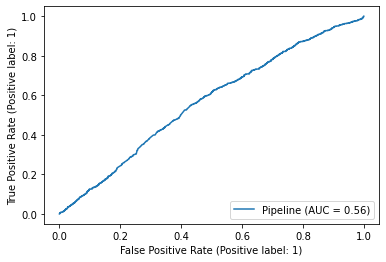

Model Name: SVM
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1882
           1       0.60      0.00      0.01       977

    accuracy                           0.66      2859
   macro avg       0.63      0.50      0.40      2859
weighted avg       0.64      0.66      0.52      2859



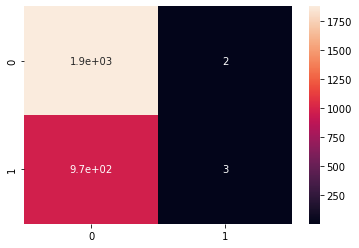

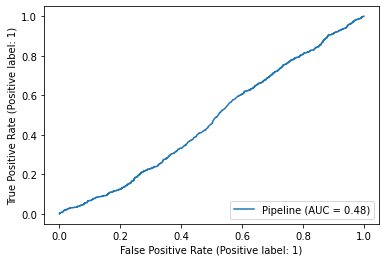

In [58]:
evaluate_models(models,train_set_predictors,train_set_targ)

Okay, not the best, not the worst.. let's try ensemble models.

In [59]:
ensemble_models = []
ensemble_models.append(('RF', RandomForestClassifier()))
ensemble_models.append(('AB', AdaBoostClassifier()))
ensemble_models.append(('GBM', GradientBoostingClassifier()))
ensemble_models.append(('ET', ExtraTreesClassifier()))
ensemble_models.append(('XGB', XGBClassifier()))

Model Name: RF
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1882
           1       0.43      0.23      0.30       977

    accuracy                           0.63      2859
   macro avg       0.55      0.54      0.53      2859
weighted avg       0.59      0.63      0.60      2859



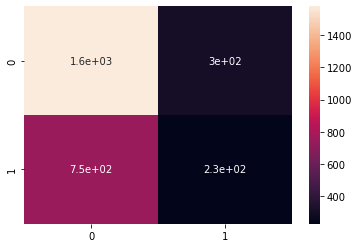

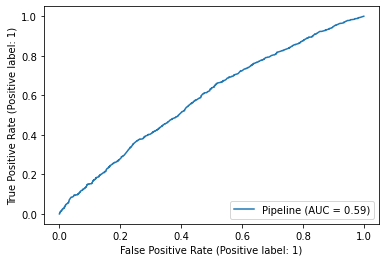

Model Name: AB
              precision    recall  f1-score   support

           0       0.66      0.97      0.78      1882
           1       0.35      0.04      0.06       977

    accuracy                           0.65      2859
   macro avg       0.50      0.50      0.42      2859
weighted avg       0.55      0.65      0.54      2859



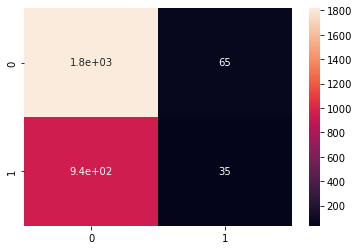

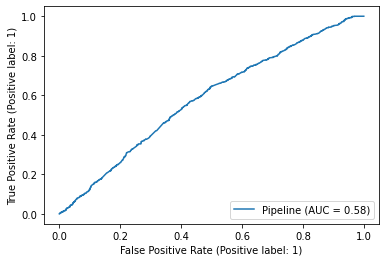

Model Name: GBM
              precision    recall  f1-score   support

           0       0.66      0.97      0.79      1882
           1       0.47      0.05      0.09       977

    accuracy                           0.66      2859
   macro avg       0.57      0.51      0.44      2859
weighted avg       0.60      0.66      0.55      2859



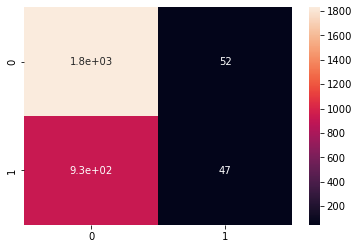

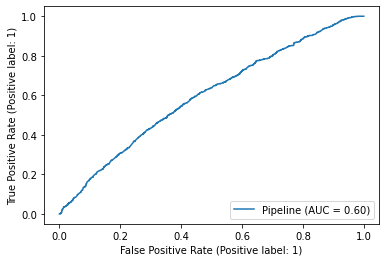

Model Name: ET
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1882
           1       0.41      0.26      0.32       977

    accuracy                           0.62      2859
   macro avg       0.54      0.53      0.53      2859
weighted avg       0.59      0.62      0.59      2859



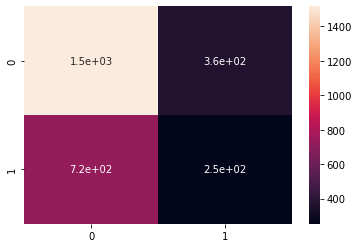

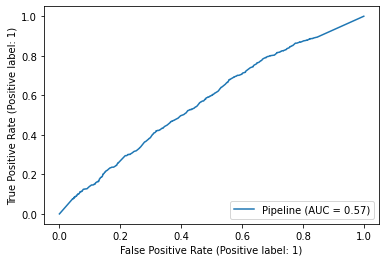

[15:42:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: XGB


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.67      0.87      0.76      1882
           1       0.42      0.18      0.25       977

    accuracy                           0.63      2859
   macro avg       0.54      0.52      0.50      2859
weighted avg       0.58      0.63      0.58      2859



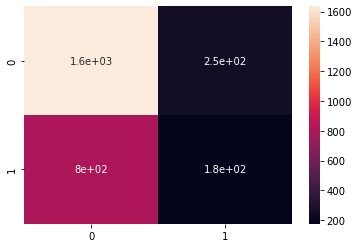

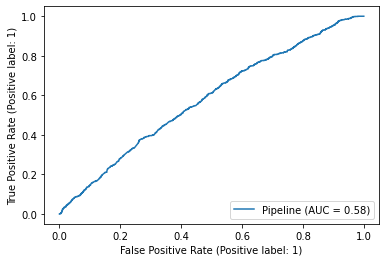

In [60]:
evaluate_models(ensemble_models,train_set_predictors,train_set_targ)

Alright, slightly better. Let's add in scaling and some kfold validation for robustness.

In [61]:
def SKFold_evaluate_scaled_models(models,X,y):
    '''
    Takes in a list of tuples, where the tuples are a model name string and the model class.
    Adds models to a Pipeline, evaluates all models, displays relative graphs and prints
    scoring information.
    '''
    
    pipelines = []
    for name, model in models:
        pipelines.append(('Scaled' + name, Pipeline([('SS', StandardScaler()),(name, model)]))) 
        
    kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
    
    for name, pipeline in pipelines:
        cv_result = cross_val_score(pipeline, X, y, cv = kfolds, scoring = 'roc_auc')
        print('=================================================================================')
        print(f'Model Name: {name}')
        print(f'All Scores: {cv_result}')
        print(f'Mean Score: {cv_result.mean()}')
        print(f'Score Std Dev: {cv_result.std()}')
        print('=================================================================================')

In [62]:
SKFold_evaluate_scaled_models(models,train_set_predictors,train_set_targ)

Model Name: ScaledLR
All Scores: [0.58788935 0.56565459 0.58524737 0.59972834 0.55532893]
Mean Score: 0.578769714367442
Score Std Dev: 0.016036636030534023
Model Name: ScaledLDA
All Scores: [0.58746434 0.56509401 0.58503087 0.60010996 0.55601879]
Mean Score: 0.5787435960207976
Score Std Dev: 0.01596765821343304
Model Name: ScaledKNN
All Scores: [0.56229055 0.56510806 0.56086617 0.55543657 0.56145573]
Mean Score: 0.5610314148368787
Score Std Dev: 0.0031532235924853335
Model Name: ScaledCART
All Scores: [0.55548859 0.52430423 0.55408865 0.52819073 0.55810795]
Mean Score: 0.5440360291865949
Score Std Dev: 0.01463319826844972
Model Name: ScaledNB
All Scores: [0.590084   0.55477108 0.56314369 0.60566677 0.55679917]
Mean Score: 0.5740929407740409
Score Std Dev: 0.020223330726280908
Model Name: ScaledSVM
All Scores: [0.56391059 0.55583788 0.5496547  0.57980187 0.57223909]
Mean Score: 0.5642888254562495
Score Std Dev: 0.010858917755482766


In [63]:
SKFold_evaluate_scaled_models(ensemble_models,train_set_predictors,train_set_targ)

Model Name: ScaledRF
All Scores: [0.58175787 0.55772843 0.59006233 0.56678013 0.579312  ]
Mean Score: 0.5751281534597867
Score Std Dev: 0.011462349022195244
Model Name: ScaledAB
All Scores: [0.57972687 0.57725804 0.58469879 0.59668818 0.56435217]
Mean Score: 0.5805448079135782
Score Std Dev: 0.010502737028881593
Model Name: ScaledGBM
All Scores: [0.60096811 0.59023422 0.60270917 0.6033024  0.56978115]
Mean Score: 0.5933990123438393
Score Std Dev: 0.012726875233520011
Model Name: ScaledET
All Scores: [0.56864063 0.55211722 0.57564925 0.56940075 0.57308796]
Mean Score: 0.5677791640357552
Score Std Dev: 0.008231520336327364
[15:43:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:16] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[15:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.59841501 0.56848858 0.59490848 0.58700505 0.57674276]
Mean Score: 0.5851119768425033
Score Std Dev: 0.011161604850705381


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Our Scaled Gradient Boosted Machine is our best performer, closing in on a ROC_AUC of nearly .6 While we aren't seeing the confusion matrices for the scaled kfold results, in the baselines, it is apparent that the ROC scores are achieved in different ways. While some classifiers, such as the GBM, achieve performance by being very conservative in predicting that most of the applicants are failures but yields few false positives, others such as XGB predict more successful candidates but are negatively impacted by their number of false positives predicted. Going forward, we will evaluate each of these models to see if the performance differs as we add features and conduct tuning. Before that, however, let's quickly generate a first solution file using our GBM to see how these classifiers perform on the test set.

In [8]:
def generate_solution(model,X_train,y_train,test,ID_col):
    
    model.fit(X_train,y_train)
    test_preds = model.predict_proba(test)[:,1]
    solution_df = pd.concat([ID_col,pd.Series(test_preds)], axis = 1)
    solution_df.columns = ['ID','Business_Sourced']
    
    iter_num = 0
    saved = 0
    while not saved:
        solution_id = 'solution' + str(iter_num)
        file_exists = path.isfile(f'./submissions/{solution_id}.csv')
        if file_exists:
            iter_num += 1
            continue
        else:
            solution_df.to_csv(f'./submissions/{solution_id}.csv', index = False)
            saved = 1

In [63]:
gbc = GradientBoostingClassifier(random_state = 4)
gbc_pipeline = Pipeline([('SS', StandardScaler()),('GBC', gbc)])
generate_solution(gbc_pipeline,train_set_predictors,train_set_targ,test_predictors,ID_col)

# Iteration, Feature Engineering, Different Modeling Strategies

## Creating some simple features

Some features that I could generate that came to mind earlier include: Are the manager and applicant the same gender? Are the office pincode and applicant pincode the same such that they live close to where they work? Has the managers grade improved since joining, or maybe later, what is there improvement per year of tenure? Does the manager has greater than zero business as a boolean column?

In [78]:
features_df = pd.DataFrame()
features_df['Mgr_App_Same_Gender'] = train_set.Applicant_Gender == train_set.Manager_Gender
features_df['Short_Commute'] = train_set.Applicant_City_PIN == train_set.Office_PIN
features_df['Manager_Grade_Change'] = train_set_predictors.Manager_Current_Designation - train_set_predictors.Manager_Joining_Designation 
features_df['Technical_Manager'] = train_set.Manager_Business.apply(lambda x: 1 if x > 0 else 0)
features_df['Receipt_Month'] = train_set.Application_Receipt_Date.dt.month
features_df['Receipt_Day'] = train_set.Application_Receipt_Date.dt.day

In [79]:
features_df.head()

Mgr_App_Same_Gender  Short_Commute  Manager_Grade_Change  \
0                 True          False                   1.0   
1                 True          False                   1.0   
2                 True          False                   0.0   
3                False           True                   2.0   
4                 True          False                   0.0   

   Technical_Manager  Receipt_Month  Receipt_Day  
0                  1              4           16  
1                  1              4           16  
2                  1              4           16  
3                  1              4           16  
4                  1              4           16

In [80]:
iter_models = []
iter_models.append(('GBM', GradientBoostingClassifier()))
iter_models.append(('XGB', XGBClassifier()))
for feature in features_df:
    added_feature_df = pd.concat([features_df[feature],train_set_predictors], axis = 1)
    print(f'Testing Feature: {feature}')
    SKFold_evaluate_scaled_models(iter_models,added_feature_df,train_set_targ)

Testing Feature: Mgr_App_Same_Gender
Model Name: ScaledGBM
All Scores: [0.60030862 0.58786675 0.603651   0.60427726 0.56982152]
Mean Score: 0.5931850306117871
Score Std Dev: 0.013095476559708615
[17:33:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model Name: ScaledXGB
All Scores: [0.58785942 0.5723045  0.59502896 0.59990386 0.57261949]
Mean Score: 0.5855432471342985
Score Std Dev: 0.011347763851285683
Testing Feature: Short_Commute
Model Name: ScaledGBM
All Scores: [0.60284096 0.58717611 0.59938218 0.60583128 0.56979461]
Mean Score: 0.5930050292882332
Score Std Dev: 0.013225931417484092
[17:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[17:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.60162028 0.56386051 0.58867833 0.57662594 0.56994261]
Mean Score: 0.5801455357291276
Score Std Dev: 0.01353264536307685
Testing Feature: Manager_Grade_Change
Model Name: ScaledGBM
All Scores: [0.60022191 0.58519335 0.59617751 0.60153005 0.56693119]
Mean Score: 0.5900108029521508
Score Std Dev: 0.01289080340992376
[17:33:52] WARNING: C:/Users

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[17:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.58279413 0.57236678 0.59731138 0.57950098 0.56935794]
Mean Score: 0.5802662419533611
Score Std Dev: 0.009786776970017372
Testing Feature: Technical_Manager
Model Name: ScaledGBM
All Scores: [0.60012359 0.58711871 0.59900545 0.60270183 0.56940197]
Mean Score: 0.5916703131357288
Score Std Dev: 0.012357610073069696
[17:33:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:56] WARNING: C:/Users/

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[17:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.59811702 0.57570761 0.59064394 0.58952842 0.56461025]
Mean Score: 0.5837214506552781
Score Std Dev: 0.011986105992939413
Testing Feature: Receipt_Month
Model Name: ScaledGBM
All Scores: [0.59868186 0.59194646 0.6069994  0.61064074 0.57646082]
Mean Score: 0.5969458565121737
Score Std Dev: 0.012134809333494931
[17:33:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:59] WARNING: C:/Users/Admi

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[17:34:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.59801504 0.58939519 0.61645257 0.60249879 0.58357409]
Mean Score: 0.5979871378560786
Score Std Dev: 0.011339184129480345
Testing Feature: Receipt_Day
Model Name: ScaledGBM
All Scores: [0.60590822 0.58348599 0.60407422 0.58676225 0.57244091]
Mean Score: 0.590534318980074
Score Std Dev: 0.012735498251782185
[17:34:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:03] WARNING: C:/Users/Adminis

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[17:34:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.58256942 0.57246632 0.59777373 0.

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [81]:
SKFold_evaluate_scaled_models(iter_models,pd.concat([features_df,train_set_predictors], axis = 1),train_set_targ)

Model Name: ScaledGBM
All Scores: [0.59986102 0.59387243 0.60858767 0.59335568 0.5843563 ]
Mean Score: 0.596006621128988
Score Std Dev: 0.008005639338151772
[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.60140839 0.59086746 0.59500939 0.60317458 0.57705527]
Mean Score: 0.5935030189105583
Score Std Dev: 0.00933571392859687


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Hmm, well none of them individually added any significant increase in performance.

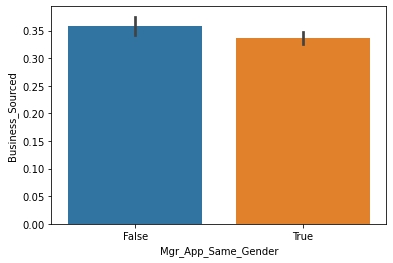

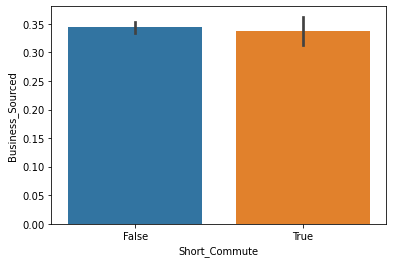

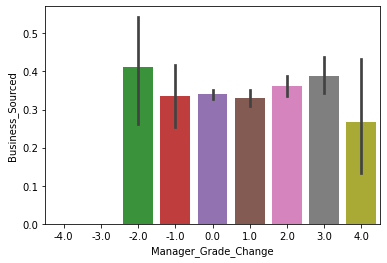

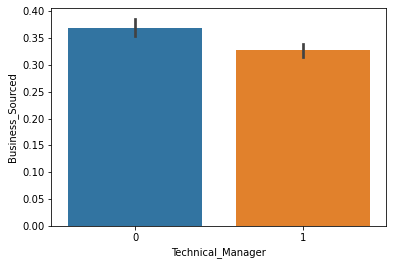

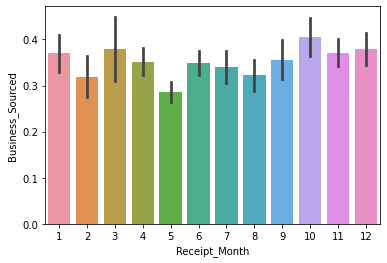

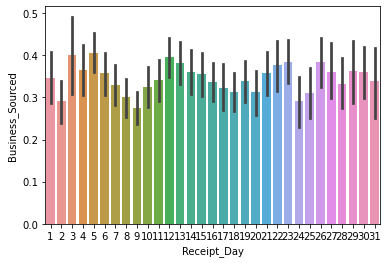

In [82]:
for feature in features_df:
    sns.barplot(data = features_df, y = train_set_targ, x = feature)
    plt.show()

Nothing sticks out here really.

## Trying to create a model from the training data that didn't include missing values

What if we sneakily take the training data that wasn't missing any values, train the model on that, then use the model on the test data which has had values randomly imputed.

In [70]:
train_NaNless = train_set[['Applicant_Occupation', 'Applicant_Qualification', 
       'Manager_DOJ', 'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Num_Application',
       'Manager_Num_Coded', 'Manager_Business', 'Manager_Num_Products',
       'Manager_Business2', 'Manager_Num_Products2', 'Business_Sourced']].dropna()
train_NaNless_preds = train_NaNless.drop(columns = 'Business_Sourced')
train_NaNless_targ = train_NaNless['Business_Sourced'].copy()

In [72]:
train_NaNless_preds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7751 entries, 0 to 9525
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Applicant_Occupation         7751 non-null   object        
 1   Applicant_Qualification      7751 non-null   object        
 2   Manager_DOJ                  7751 non-null   datetime64[ns]
 3   Manager_Joining_Designation  7751 non-null   object        
 4   Manager_Current_Designation  7751 non-null   object        
 5   Manager_Grade                7751 non-null   float64       
 6   Manager_Status               7751 non-null   object        
 7   Manager_Num_Application      7751 non-null   float64       
 8   Manager_Num_Coded            7751 non-null   float64       
 9   Manager_Business             7751 non-null   float64       
 10  Manager_Num_Products         7751 non-null   float64       
 11  Manager_Business2            7751 non-null 

Okay, now just need to conduct a few steps to prep this df for passing to the models. First, drop Business and Num_Products versions 2.

In [73]:
train_NaNless_preds.drop(columns = ['Manager_Business2', 'Manager_Num_Products2'], inplace = True)

One hot encode the non-ordinal variables...

In [75]:
non_ordinal = ['Applicant_Occupation', 'Applicant_Qualification', 'Manager_Status']
for column in non_ordinal:
    for category in train_NaNless_preds[column].value_counts()[train_NaNless_preds[column].value_counts() <= 10].index:
        train_NaNless_preds[column] = train_NaNless_preds[column].str.replace(category,'Others')

In [76]:
for column in non_ordinal:
    dummies_train = pd.get_dummies(train_NaNless_preds[column], prefix = column)
    train_NaNless_preds = pd.concat([train_NaNless_preds, dummies_train], axis = 1)
    train_NaNless_preds.drop(columns = [column], inplace = True)

Ordinally Encode the graded columns..

In [77]:
ordinal = ['Manager_Joining_Designation','Manager_Current_Designation']
ordenc2 = OrdinalEncoder()
ordenc2.fit(train_NaNless_preds[ordinal])
train_NaNless_preds[ordinal] = ordenc2.transform(train_NaNless_preds[ordinal])

Turn DOJ into YOJ...

In [78]:
train_NaNless_preds['Manager_YOJ'] = train_NaNless_preds['Manager_DOJ'].dt.year
train_NaNless_preds = train_NaNless_preds.drop(columns = ['Manager_DOJ'])

In [79]:
train_NaNless_preds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7751 entries, 0 to 9525
Data columns (total 20 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Manager_Joining_Designation                                 7751 non-null   float64
 1   Manager_Current_Designation                                 7751 non-null   float64
 2   Manager_Grade                                               7751 non-null   float64
 3   Manager_Num_Application                                     7751 non-null   float64
 4   Manager_Num_Coded                                           7751 non-null   float64
 5   Manager_Business                                            7751 non-null   float64
 6   Manager_Num_Products                                        7751 non-null   float64
 7   Applicant_Occupation_Business                               7751 non-null   uint8  
 8 

Looks good to go! Let's try our baselines over.

Model Name: LR
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      1539
           1       0.00      0.00      0.00       787

    accuracy                           0.66      2326
   macro avg       0.33      0.50      0.40      2326
weighted avg       0.44      0.66      0.53      2326



C:\Users\mattl\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


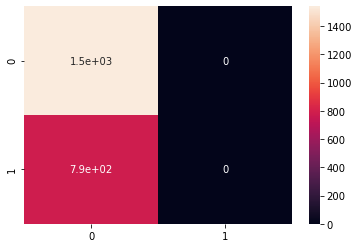

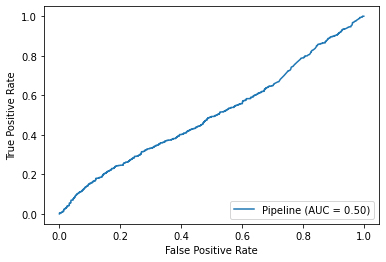

Model Name: LDA
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      1539
           1       0.49      0.05      0.10       787

    accuracy                           0.66      2326
   macro avg       0.58      0.51      0.44      2326
weighted avg       0.61      0.66      0.56      2326



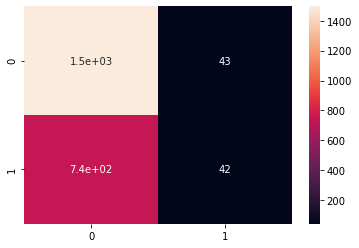

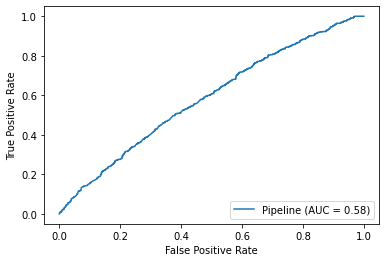

Model Name: KNN
              precision    recall  f1-score   support

           0       0.67      0.76      0.72      1539
           1       0.38      0.28      0.32       787

    accuracy                           0.60      2326
   macro avg       0.52      0.52      0.52      2326
weighted avg       0.57      0.60      0.58      2326



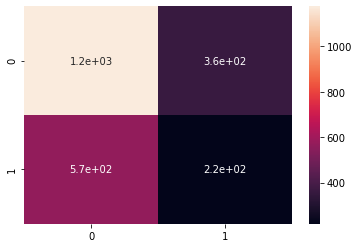

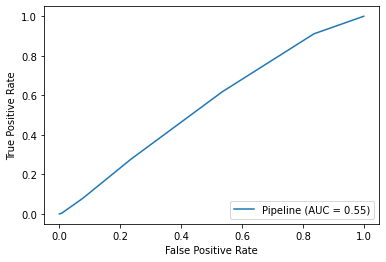

Model Name: CART
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1539
           1       0.38      0.31      0.34       787

    accuracy                           0.59      2326
   macro avg       0.53      0.52      0.52      2326
weighted avg       0.58      0.59      0.58      2326



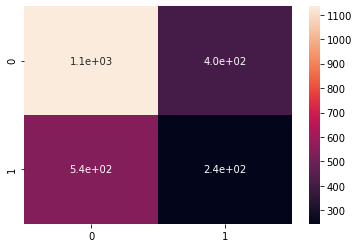

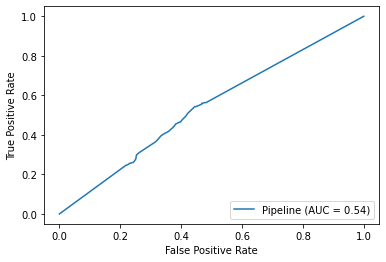

Model Name: NB
              precision    recall  f1-score   support

           0       0.66      0.99      0.80      1539
           1       0.43      0.01      0.01       787

    accuracy                           0.66      2326
   macro avg       0.55      0.50      0.41      2326
weighted avg       0.58      0.66      0.53      2326



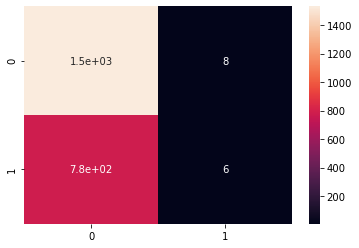

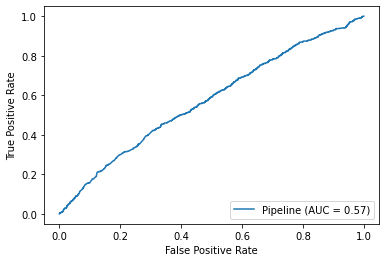

Model Name: SVM
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      1539
           1       1.00      0.00      0.01       787

    accuracy                           0.66      2326
   macro avg       0.83      0.50      0.40      2326
weighted avg       0.78      0.66      0.53      2326



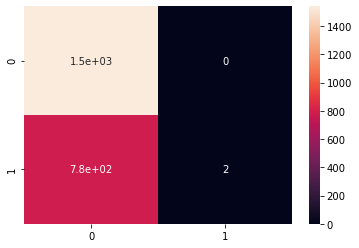

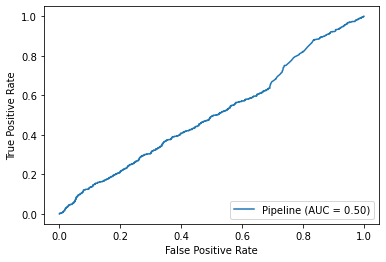

In [82]:
evaluate_models(models, train_NaNless_preds, train_NaNless_targ)

And the ensemble models...

Model Name: RF
              precision    recall  f1-score   support

           0       0.68      0.80      0.74      1539
           1       0.41      0.27      0.32       787

    accuracy                           0.62      2326
   macro avg       0.54      0.53      0.53      2326
weighted avg       0.59      0.62      0.60      2326



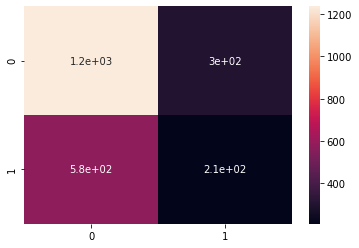

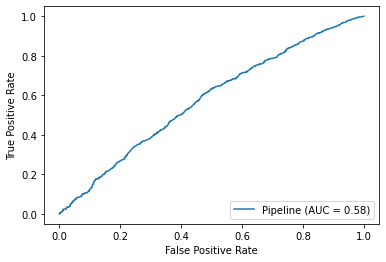

Model Name: AB
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      1539
           1       0.55      0.07      0.12       787

    accuracy                           0.67      2326
   macro avg       0.61      0.52      0.46      2326
weighted avg       0.63      0.67      0.57      2326



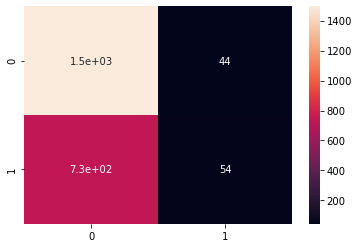

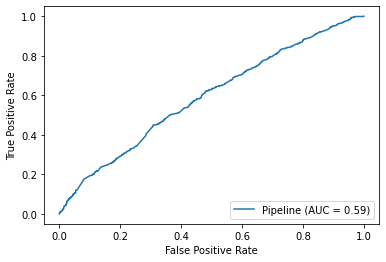

Model Name: GBM
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      1539
           1       0.55      0.07      0.13       787

    accuracy                           0.67      2326
   macro avg       0.61      0.52      0.46      2326
weighted avg       0.63      0.67      0.57      2326



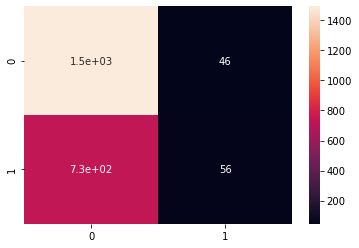

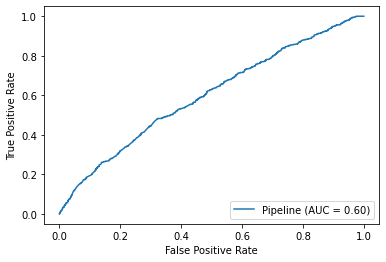

Model Name: ET
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      1539
           1       0.40      0.27      0.33       787

    accuracy                           0.62      2326
   macro avg       0.54      0.53      0.53      2326
weighted avg       0.59      0.62      0.59      2326



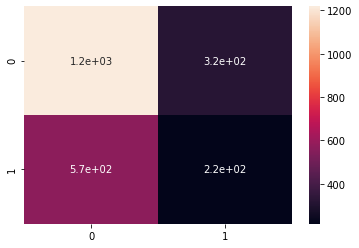

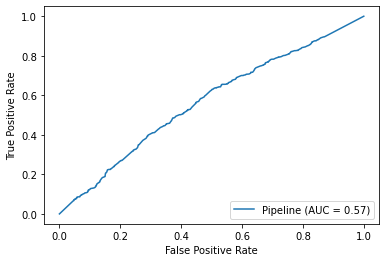

Model Name: XGB
              precision    recall  f1-score   support

           0       0.68      0.87      0.77      1539
           1       0.45      0.21      0.28       787

    accuracy                           0.65      2326
   macro avg       0.57      0.54      0.52      2326
weighted avg       0.60      0.65      0.60      2326



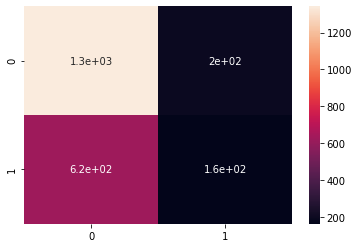

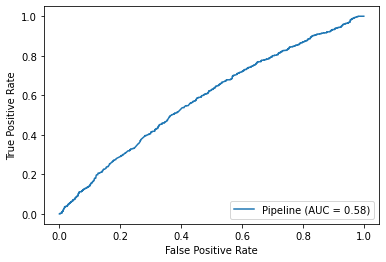

In [83]:
evaluate_models(ensemble_models, train_NaNless_preds, train_NaNless_targ)

In [84]:
SKFold_evaluate_scaled_models(models, train_NaNless_preds, train_NaNless_targ)

Model Name: ScaledLR
All Scores: [0.59506618 0.59447021 0.58594418 0.59901718 0.580754  ]
Mean Score: 0.5910503516272728
Score Std Dev: 0.00668402017810514
Model Name: ScaledLDA
All Scores: [0.59484049 0.59446929 0.58617213 0.59863882 0.58051064]
Mean Score: 0.5909262752136653
Score Std Dev: 0.006609764198265407
Model Name: ScaledKNN
All Scores: [0.56754937 0.58038516 0.5695061  0.57437332 0.57581145]
Mean Score: 0.5735250807378205
Score Std Dev: 0.004579716576503006
Model Name: ScaledCART
All Scores: [0.5743944  0.56080084 0.56912466 0.5698027  0.54011803]
Mean Score: 0.5628481237873879
Score Std Dev: 0.012181347872974275
Model Name: ScaledNB
All Scores: [0.58667527 0.57749719 0.58017835 0.59179805 0.57284335]
Mean Score: 0.5817984426988126
Score Std Dev: 0.006709615326590333
Model Name: ScaledSVM
All Scores: [0.58062566 0.57034621 0.59023936 0.5656132  0.56737184]
Mean Score: 0.5748392529580049
Score Std Dev: 0.009292101934896317


In [85]:
SKFold_evaluate_scaled_models(ensemble_models, train_NaNless_preds, train_NaNless_targ)

Model Name: ScaledRF
All Scores: [0.59421847 0.57845862 0.5941384  0.60452176 0.58102399]
Mean Score: 0.5904722490151172
Score Std Dev: 0.00957559744684564
Model Name: ScaledAB
All Scores: [0.58547892 0.59901081 0.58879722 0.59088246 0.58802364]
Mean Score: 0.5904386107064166
Score Std Dev: 0.004621782460385258
Model Name: ScaledGBM
All Scores: [0.60734338 0.60376925 0.5916907  0.61036154 0.60217171]
Mean Score: 0.6030673159031014
Score Std Dev: 0.006359442524101733
Model Name: ScaledET
All Scores: [0.56842552 0.56748397 0.58536787 0.59389464 0.58184408]
Mean Score: 0.5794032177788215
Score Std Dev: 0.0101401610172869
Model Name: ScaledXGB
All Scores: [0.59543683 0.58454156 0.58195323 0.60792883 0.58937086]
Mean Score: 0.59184626122529
Score Std Dev: 0.009261745746625999


Hmm well.. it did improve seem to improve the results a tiny bit, but probably not statistically significantly so.

In [88]:
gbc = GradientBoostingClassifier(random_state = 4)
gbc_pipeline = Pipeline([('SS', StandardScaler()),('GBC', gbc)])
generate_solution(gbc_pipeline,train_NaNless_preds,train_NaNless_targ,test_predictors[train_NaNless_preds.columns],ID_col)

On the test set however, based on the solution checker, it got 6 points worse! So, not a good solution.

## Trying Iterative Imputer

Sci-Kit Learn has a iterative imputer that fills missing values based on iterative regression, modeling each feature individually based on the others. We need to still apply processing steps to turn all the columns to numerical columns, but leave in NaNs.

In [9]:
II_train = train_set[['Applicant_Occupation', 'Applicant_Qualification', 
       'Manager_DOJ', 'Manager_Joining_Designation', 'Manager_Current_Designation',
       'Manager_Grade', 'Manager_Status', 'Manager_Num_Application',
       'Manager_Num_Coded', 'Manager_Business', 'Manager_Num_Products',
       'Manager_Business2', 'Manager_Num_Products2', 'Business_Sourced']].copy()
II_train_preds = II_train.drop(columns = 'Business_Sourced')
II_train_targ = II_train['Business_Sourced'].copy()

In [10]:
II_train_preds.drop(columns = ['Manager_Business2', 'Manager_Num_Products2'], inplace = True)

In [11]:
non_ordinal = ['Applicant_Occupation', 'Applicant_Qualification', 'Manager_Status']
for column in non_ordinal:
    for category in II_train_preds[column].value_counts()[II_train_preds[column].value_counts() <= 10].index:
        II_train_preds[column] = II_train_preds[column].str.replace(category,'Others')

In [12]:
for column in non_ordinal:
    dummies_train = pd.get_dummies(II_train_preds[column], prefix = column, dummy_na = True)
    II_train_preds = pd.concat([II_train_preds, dummies_train], axis = 1)
    II_train_preds.drop(columns = [column], inplace = True)

In [28]:
for column in non_ordinal:
    for dummy in II_train_preds.columns:
        if (column in dummy) and ('nan' not in dummy):
            II_train_preds[dummy].loc[II_train_preds[column + '_nan'] == 1.0] = np.nan
    II_train_preds.drop(columns = [column + '_nan'], inplace = True)

In [29]:
II_train_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 20 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Manager_DOJ                                                 8844 non-null   object 
 1   Manager_Joining_Designation                                 8844 non-null   object 
 2   Manager_Current_Designation                                 8844 non-null   object 
 3   Manager_Grade                                               8844 non-null   float64
 4   Manager_Num_Application                                     8844 non-null   float64
 5   Manager_Num_Coded                                           8844 non-null   float64
 6   Manager_Business                                            8844 non-null   float64
 7   Manager_Num_Products                                        8844 non-null   float64
 8 

For the ordinals, we need to do something a bit sneaky. For some reason, though I have checked my versioning, OrdinalEncoder will not handle NaN as input / allow NaN passthrough, even though it is supposed to be implemented for the current version. So, I will replace the NaNs with level 0 for the meantime, then replace the 0th ordinal category with NaNs after using the encoder.

In [30]:
ordinal = ['Manager_Joining_Designation','Manager_Current_Designation']
II_train_preds[ordinal] = II_train_preds[ordinal].replace('Other',np.nan)
II_train_preds[ordinal].value_counts(dropna = False)

Manager_Joining_Designation  Manager_Current_Designation
Level 1                      Level 1                        2444
Level 2                      Level 2                        1960
Level 1                      Level 2                        1247
Level 3                      Level 3                        1097
NaN                          NaN                             683
Level 1                      Level 3                         611
Level 2                      Level 4                         455
                             Level 3                         324
Level 1                      Level 4                         302
Level 4                      Level 4                         200
Level 3                      Level 4                          49
Level 2                      Level 5                          48
NaN                          Level 1                          35
Level 1                      Level 5                          28
NaN                          Leve

In [31]:
ordenc3 = OrdinalEncoder(dtype = np.float64, handle_unknown = 'use_encoded_value', unknown_value = np.nan)
ordenc3.fit(II_train_preds[ordinal].fillna(value = "Level 0"))
II_train_preds[ordinal] = ordenc3.transform(II_train_preds[ordinal].fillna(value = "Level 0"))

In [32]:
II_train_preds[ordinal].value_counts(dropna = False)

Manager_Joining_Designation  Manager_Current_Designation
1.0                          1.0                            2444
2.0                          2.0                            1960
1.0                          2.0                            1247
3.0                          3.0                            1097
0.0                          0.0                             683
1.0                          3.0                             611
2.0                          4.0                             455
                             3.0                             324
1.0                          4.0                             302
4.0                          4.0                             200
3.0                          4.0                              49
2.0                          5.0                              48
0.0                          1.0                              35
1.0                          5.0                              28
0.0                          4.0 

In [33]:
II_train_preds[ordinal] = II_train_preds[ordinal].replace(0.0,np.nan)
II_train_preds[ordinal].value_counts(dropna = False)

Manager_Joining_Designation  Manager_Current_Designation
1.0                          1.0                            2444
2.0                          2.0                            1960
1.0                          2.0                            1247
3.0                          3.0                            1097
NaN                          NaN                             683
1.0                          3.0                             611
2.0                          4.0                             455
                             3.0                             324
1.0                          4.0                             302
4.0                          4.0                             200
3.0                          4.0                              49
2.0                          5.0                              48
NaN                          1.0                              35
1.0                          5.0                              28
NaN                          4.0 

All good, finally, produce YOJ.

In [34]:
II_train_preds['Manager_DOJ'] = pd.to_datetime(II_train_preds['Manager_DOJ'], infer_datetime_format = True)
II_train_preds['Manager_YOJ'] = II_train_preds['Manager_DOJ'].dt.year
II_train_preds = II_train_preds.drop(columns = ['Manager_DOJ'])

In [35]:
II_train_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9527 entries, 0 to 9526
Data columns (total 20 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Manager_Joining_Designation                                 8786 non-null   float64
 1   Manager_Current_Designation                                 8844 non-null   float64
 2   Manager_Grade                                               8844 non-null   float64
 3   Manager_Num_Application                                     8844 non-null   float64
 4   Manager_Num_Coded                                           8844 non-null   float64
 5   Manager_Business                                            8844 non-null   float64
 6   Manager_Num_Products                                        8844 non-null   float64
 7   Applicant_Occupation_Business                               8306 non-null   float64
 8 

In [43]:
iterimp = IterativeImputer(random_state = 4)
II_train_preds_filled = pd.DataFrame(iterimp.fit_transform(II_train_preds))

In [45]:
II_train_preds_filled.columns = II_train_preds.columns
II_train_preds_filled.head()

Manager_Joining_Designation  Manager_Current_Designation  Manager_Grade  \
0                          1.0                          2.0            3.0   
1                          1.0                          2.0            3.0   
2                          1.0                          1.0            2.0   
3                          1.0                          3.0            4.0   
4                          1.0                          1.0            2.0   

   Manager_Num_Application  Manager_Num_Coded  Manager_Business  \
0                      2.0                1.0          335249.0   
1                      2.0                1.0          335249.0   
2                      0.0                0.0          357184.0   
3                      0.0                0.0          318356.0   
4                      2.0                1.0          230402.0   

   Manager_Num_Products  Applicant_Occupation_Business  \
0                  28.0                            0.0   
1                  28.0                            0.0   
2                  24.0                            1.0   
3                  22.0                            0.0   
4                  17.0                            0.0   

   Applicant_Occupation_Others  Applicant_Occupation_Salaried  \
0                          1.0                            0.0   
1                          1.0                            0.0   
2                          0.0                            0.0   
3                          0.0                            1.0   
4                          1.0                            0.0   

   Applicant_Occupation_Self Employed  Applicant_Occupation_Student  \
0                                 0.0                           0.0   
1                                 0.0                           0.0   
2                                 0.0                           0.0   
3                                 0.0                           0.0   
4                                 0.0                           0.0   

   Applicant_Qualification_Class X  Applicant_Qualification_Class XII  \
0                              0.0                                0.0   
1                              0.0                                1.0   
2                              0.0                                1.0   
3                              0.0                                1.0   
4                              0.0                                1.0   

   Applicant_Qualification_Graduate  \
0                               1.0   
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   

   Applicant_Qualification_Masters of Business Administration  \
0                                                0.0            
1                                                0.0            
2                                                0.0            
3                                                0.0            
4                                                0.0            

   Applicant_Qualification_Others  Manager_Status_Confirmation  \
0                             0.0                          1.0   
1                             0.0                          1.0   
2                             0.0                          1.0   
3                             0.0                          1.0   
4                             0.0                          1.0   

   Manager_Status_Probation  Manager_YOJ  
0                       0.0       2005.0  
1                       0.0       2005.0  
2                       0.0       2006.0  
3                       0.0       2003.0  
4                       0.0       2006.0

In [42]:
II_train_preds.head()

Manager_Joining_Designation  Manager_Current_Designation  Manager_Grade  \
0                          1.0                          2.0            3.0   
1                          1.0                          2.0            3.0   
2                          1.0                          1.0            2.0   
3                          1.0                          3.0            4.0   
4                          1.0                          1.0            2.0   

   Manager_Num_Application  Manager_Num_Coded  Manager_Business  \
0                      2.0                1.0          335249.0   
1                      2.0                1.0          335249.0   
2                      0.0                0.0          357184.0   
3                      0.0                0.0          318356.0   
4                      2.0                1.0          230402.0   

   Manager_Num_Products  Applicant_Occupation_Business  \
0                  28.0                            0.0   
1                  28.0                            0.0   
2                  24.0                            1.0   
3                  22.0                            0.0   
4                  17.0                            0.0   

   Applicant_Occupation_Others  Applicant_Occupation_Salaried  \
0                          1.0                            0.0   
1                          1.0                            0.0   
2                          0.0                            0.0   
3                          0.0                            1.0   
4                          1.0                            0.0   

   Applicant_Occupation_Self Employed  Applicant_Occupation_Student  \
0                                 0.0                           0.0   
1                                 0.0                           0.0   
2                                 0.0                           0.0   
3                                 0.0                           0.0   
4                                 0.0                           0.0   

   Applicant_Qualification_Class X  Applicant_Qualification_Class XII  \
0                              0.0                                0.0   
1                              0.0                                1.0   
2                              0.0                                1.0   
3                              0.0                                1.0   
4                              0.0                                1.0   

   Applicant_Qualification_Graduate  \
0                               1.0   
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   

   Applicant_Qualification_Masters of Business Administration  \
0                                                0.0            
1                                                0.0            
2                                                0.0            
3                                                0.0            
4                                                0.0            

   Applicant_Qualification_Others  Manager_Status_Confirmation  \
0                             0.0                          1.0   
1                             0.0                          1.0   
2                             0.0                          1.0   
3                             0.0                          1.0   
4                             0.0                          1.0   

   Manager_Status_Probation  Manager_YOJ  
0                       0.0       2005.0  
1                       0.0       2005.0  
2                       0.0       2006.0  
3                       0.0       2003.0  
4                       0.0       2006.0

In [46]:
II_train_preds_filled.isna().sum()

Manager_Joining_Designation                                   0
Manager_Current_Designation                                   0
Manager_Grade                                                 0
Manager_Num_Application                                       0
Manager_Num_Coded                                             0
Manager_Business                                              0
Manager_Num_Products                                          0
Applicant_Occupation_Business                                 0
Applicant_Occupation_Others                                   0
Applicant_Occupation_Salaried                                 0
Applicant_Occupation_Self Employed                            0
Applicant_Occupation_Student                                  0
Applicant_Qualification_Class X                               0
Applicant_Qualification_Class XII                             0
Applicant_Qualification_Graduate                              0
Applicant_Qualification_Masters of Busin

Well.. filled them with something!

Model Name: LR
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1882
           1       1.00      0.00      0.00       977

    accuracy                           0.66      2859
   macro avg       0.83      0.50      0.40      2859
weighted avg       0.78      0.66      0.52      2859



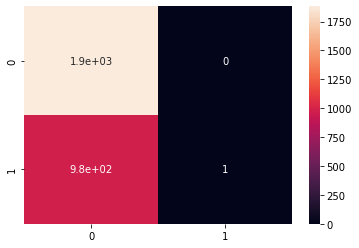

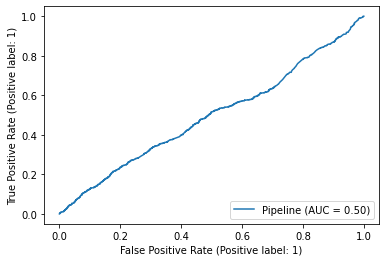

Model Name: LDA
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      1882
           1       0.52      0.03      0.05       977

    accuracy                           0.66      2859
   macro avg       0.59      0.51      0.42      2859
weighted avg       0.61      0.66      0.54      2859



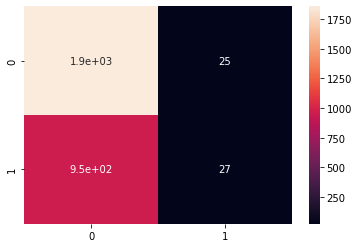

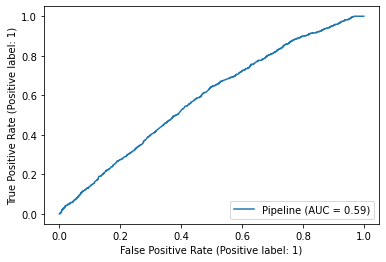

Model Name: KNN
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      1882
           1       0.39      0.29      0.34       977

    accuracy                           0.60      2859
   macro avg       0.53      0.53      0.53      2859
weighted avg       0.58      0.60      0.59      2859



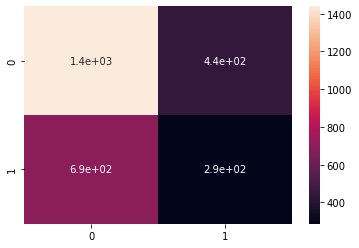

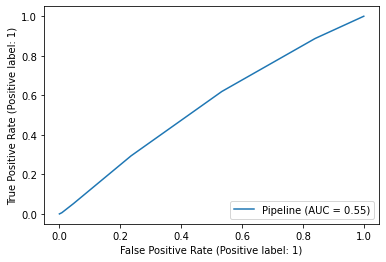

Model Name: CART
              precision    recall  f1-score   support

           0       0.67      0.74      0.71      1882
           1       0.38      0.31      0.34       977

    accuracy                           0.59      2859
   macro avg       0.53      0.53      0.52      2859
weighted avg       0.57      0.59      0.58      2859



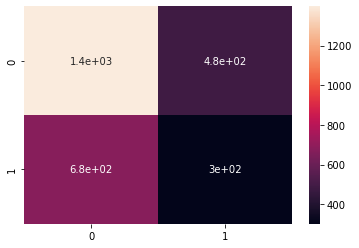

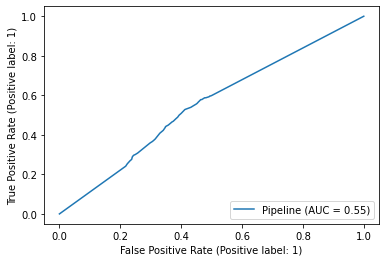

Model Name: NB
              precision    recall  f1-score   support

           0       0.66      0.98      0.79      1882
           1       0.40      0.03      0.06       977

    accuracy                           0.65      2859
   macro avg       0.53      0.50      0.42      2859
weighted avg       0.57      0.65      0.54      2859



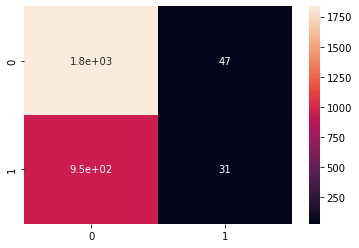

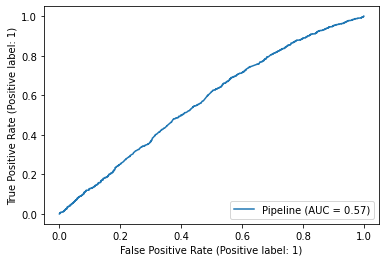

Model Name: SVM
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1882
           1       0.60      0.00      0.01       977

    accuracy                           0.66      2859
   macro avg       0.63      0.50      0.40      2859
weighted avg       0.64      0.66      0.52      2859



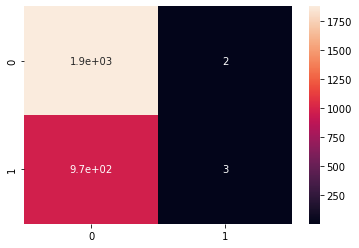

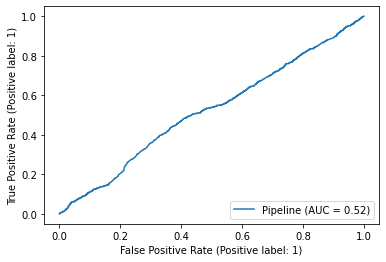

In [47]:
evaluate_models(models, II_train_preds_filled, II_train_targ)

Model Name: RF
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1882
           1       0.43      0.23      0.29       977

    accuracy                           0.63      2859
   macro avg       0.55      0.53      0.52      2859
weighted avg       0.59      0.63      0.59      2859



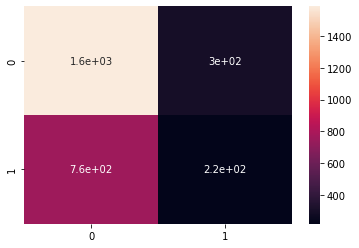

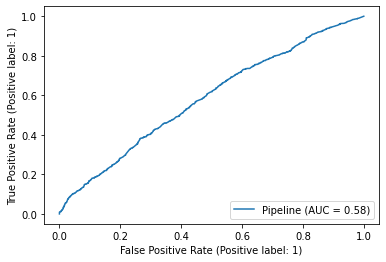

Model Name: AB
              precision    recall  f1-score   support

           0       0.66      0.97      0.79      1882
           1       0.40      0.04      0.08       977

    accuracy                           0.65      2859
   macro avg       0.53      0.50      0.43      2859
weighted avg       0.57      0.65      0.54      2859



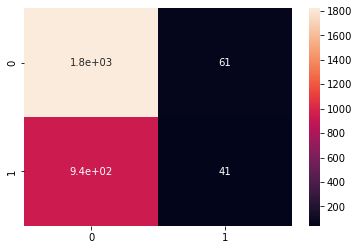

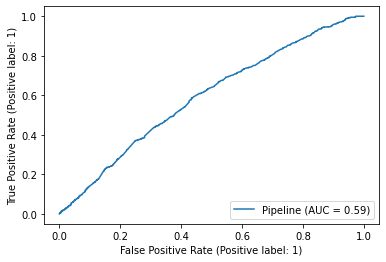

Model Name: GBM
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      1882
           1       0.54      0.06      0.10       977

    accuracy                           0.66      2859
   macro avg       0.61      0.52      0.45      2859
weighted avg       0.62      0.66      0.56      2859



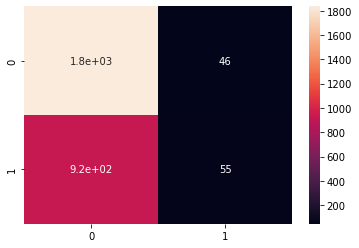

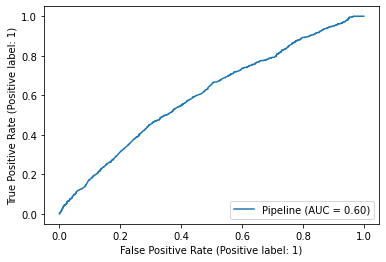

Model Name: ET
              precision    recall  f1-score   support

           0       0.67      0.81      0.74      1882
           1       0.41      0.25      0.31       977

    accuracy                           0.62      2859
   macro avg       0.54      0.53      0.52      2859
weighted avg       0.58      0.62      0.59      2859



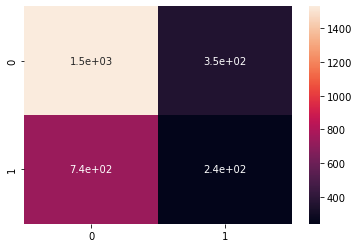

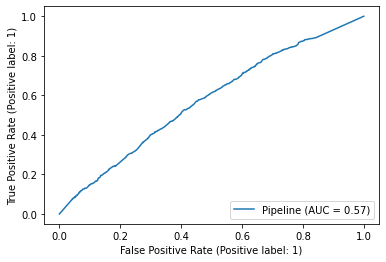

[15:18:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: XGB


C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1882
           1       0.44      0.20      0.28       977

    accuracy                           0.64      2859
   macro avg       0.56      0.53      0.52      2859
weighted avg       0.59      0.64      0.59      2859



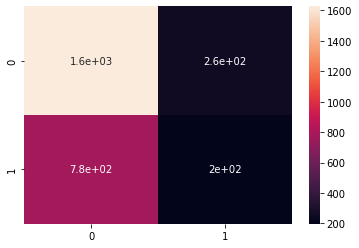

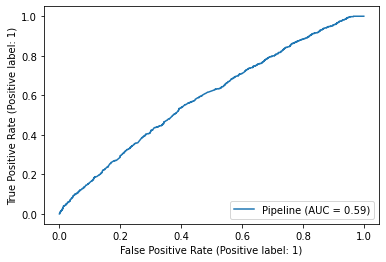

In [48]:
evaluate_models(ensemble_models, II_train_preds_filled, II_train_targ)

In [49]:
SKFold_evaluate_scaled_models(models, II_train_preds_filled, II_train_targ)

Model Name: ScaledLR
All Scores: [0.58302984 0.56836401 0.58666073 0.59959807 0.55271565]
Mean Score: 0.5780736622061282
Score Std Dev: 0.01611773838465165
Model Name: ScaledLDA
All Scores: [0.57665594 0.56499692 0.5768192  0.5965096  0.55318657]
Mean Score: 0.5736336472637033
Score Std Dev: 0.014389350697003502
Model Name: ScaledKNN
All Scores: [0.55702985 0.56082989 0.57045328 0.55872809 0.55151574]
Mean Score: 0.5597113689098842
Score Std Dev: 0.006196215694390484
Model Name: ScaledCART
All Scores: [0.55563697 0.53325261 0.55419812 0.55618086 0.54971586]
Mean Score: 0.5497968849215584
Score Std Dev: 0.008578489513463903
Model Name: ScaledNB
All Scores: [0.58087305 0.55944373 0.57344023 0.59009658 0.54722123]
Mean Score: 0.5702149634751614
Score Std Dev: 0.015257831593940762
Model Name: ScaledSVM
All Scores: [0.56364557 0.55538173 0.55508369 0.59857184 0.57261399]
Mean Score: 0.5690593617632911
Score Std Dev: 0.016095515663961165


In [50]:
SKFold_evaluate_scaled_models(ensemble_models, II_train_preds_filled, II_train_targ)

Model Name: ScaledRF
All Scores: [0.58151423 0.56157854 0.5863262  0.57097801 0.58180296]
Mean Score: 0.5764399864619248
Score Std Dev: 0.008977107795888778
Model Name: ScaledAB
All Scores: [0.58960098 0.57139464 0.58601429 0.59043784 0.56770178]
Mean Score: 0.5810299070611038
Score Std Dev: 0.009563408480573302
Model Name: ScaledGBM
All Scores: [0.6110474  0.58574965 0.60975701 0.60360452 0.5733277 ]
Mean Score: 0.5966972562348618
Score Std Dev: 0.014766044686704756
Model Name: ScaledET
All Scores: [0.56678367 0.55614198 0.57204461 0.56983742 0.57383103]
Mean Score: 0.5677277390404574
Score Std Dev: 0.006252317594730768
[15:20:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[15:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name: ScaledXGB
All Scores: [0.57998884 0.57391782 0.60741955 0.

C:\Users\mattl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
